# Configuration


In [2]:
import os

simulation_root = "/Users/user_name/Library/Application Support/DefaultCompany/Sumobot/Logs/Batch/20251231_170916_batch"

converted_dir = "converted"
summarized_dir = "result"
batch_checkpoint_dir = "batched"
arena_heatmaps_output = "result/arena_heatmaps"

os.makedirs(converted_dir, exist_ok=True)
os.makedirs(batch_checkpoint_dir, exist_ok=True)
os.makedirs(summarized_dir, exist_ok=True)
os.makedirs(arena_heatmaps_output, exist_ok=True)

# Data Compiling

## Convert Simulation Log to Parquet / CSV

In [ ]:
from compile.log_to_parquet import ( 
    convert_all_configs
)

convert_all_configs(simulation_root, converted_dir)

In [ ]:
# from compile.log_to_csv import ( 
#     convert_all_configs
# )

# convert_all_configs(simulation_root, converted_dir)

## Generate Summarization CSV

### Import Functions

In [ ]:
from compile.generator import (
        batch_process_csvs,
        generate_timebins_from_batches,
        generate
    )

### Generate Batched CSV

Process CSVs in batches and save checkpoints

Structure: base_dir/BotA_vs_BotB/ConfigFolder/*.csv

In [ ]:
import time

timebin_size = 5
batch_size = 2 # if there's 156 matchup simulation folder, it will generate 156 / 2 = 78 summarization batch csv
input_format = "auto"  # "csv", "parquet", or "auto" (auto prefers parquet over csv)

start = time.time()

batch_process_csvs(
    converted_dir, 
    batch_size=batch_size,
    time_bin_size=timebin_size,
    checkpoint_dir=batch_checkpoint_dir,
    compute_timebins=True,
    input_format=input_format)

elapsed_seconds = time.time() - start
hours, remainder = divmod(elapsed_seconds, 3600)
minutes, seconds = divmod(remainder, 60)
processing_time = f"{int(hours):02d}:{int(minutes):02d}:{seconds:.2f}"
print(f"\nProcessing Time: {processing_time}")

### Generate Final Summarization CSV from Batches

Generate timebin summaries from batched timebin checkpoints
Loads batch files and creates final summaries

In [ ]:
generate(batch_checkpoint_dir, summarized_dir) # generate summarization csv
generate_timebins_from_batches(batch_checkpoint_dir, summarized_dir) # generate csv containing batched timebins

## Generate Arena Heatmaps Figure

### Import Functions

In [ ]:
import time
from compile.arena_generator import ( 
    create_phased_heatmaps_all_bots
)

### Run to Generate Arena Heatmap figures

In [ ]:


start = time.time()

create_phased_heatmaps_all_bots(
            converted_dir,
            output_dir = arena_heatmaps_output,
            actor_position="both",
            chunksize=50000,
            max_configs=None,  # None for all configs, only fill to test, e.g. 2 or 5 configs
            mode="all",  # Generate both heatmaps and position distributions
            use_timer=False, # Group by existing Timer configuration
            use_time_windows=True, # Use time windows [skip_initial-15, 15-30, 30-45, 45-60]
            include_distance_over_time=True,  
            skip_initial=2.5
        )

elapsed_seconds = time.time() - start
hours, remainder = divmod(elapsed_seconds, 3600)
minutes, seconds = divmod(remainder, 60)
processing_time = f"{int(hours):02d}:{int(minutes):02d}:{seconds:.2f}"
print(f"\nProcessing Time: {processing_time}")

# Plotting

## Import Functions

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

from plotting.overall_analyzer import (
        plot_action_radar,
        plot_collision_radar,
        plot_winrate_matrix,
        plot_overall_bot_metrics,
        plot_grouped_config_winrates,
        plot_time_related,
        plot_action_distribution_stacked,
        plot_action_timebins_intensity,
        plot_collision_timebins_intensity,
        plot_collision_distribution_stacked,
        plot_action_win_related,
        plot_all_correlations,
        plot_full_cross_heatmap_half,
    )
    
from plotting.individual_analyzer import (
    plot_individual_bot_correlations,
)

2026-01-03 09:34:39.264 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-03 09:34:39.266 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-03 09:34:39.267 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-03 09:34:39.268 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-03 09:34:39.269 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## Load Data

In [4]:
# Load summary data
df_sum = pd.read_csv(f"{summarized_dir}/summary_bot.csv").rename(columns={"Duration": "Duration (ms)"})
df = pd.read_csv(f"{summarized_dir}/summary_matchup.csv")
df_timebins = pd.read_csv(f"{summarized_dir}/summary_action_timebins.csv")
df_collision_timebins = pd.read_csv(f"{summarized_dir}/summary_collision_timebins.csv")

# Configuration
cfg = {
    "Timer": sorted(df["Timer"].unique().tolist()),
    "ActInterval": sorted(df["ActInterval"].unique().tolist()),
    "Round": sorted(df["Round"].unique().tolist()),
    "SkillLeft": sorted(df["SkillLeft"].unique().tolist()),
    "SkillRight": sorted(df["SkillRight"].unique().tolist()),
    "Bots": sorted(df["Bot_L"].unique().tolist()),
}
bots = str.join(", ", cfg["Bots"])

# Display settings
width = 10
height = 6

print("Data loaded successfully!")
print(f"\nBots in experiment: {bots}")
print(f"\nConfiguration:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

Data loaded successfully!

Bots in experiment: Bot_BT, Bot_GA

Configuration:
  Timer: [15.0, 45.0]
  ActInterval: [0.1]
  Round: ['BestOf1', 'BestOf5']
  SkillLeft: ['Stone']
  SkillRight: ['Stone']
  Bots: ['Bot_BT', 'Bot_GA']


## Summary Matchup Data

In [5]:
# Calculate experiment statistics
num_configs = len(df)  # Each row is a unique configuration
num_bots = len(cfg["Bots"])
num_matchups = len(df.groupby(['Bot_L', 'Bot_R']))
total_games = df["Games"].sum()

# Calculate configuration combinations
num_timer_configs = len(cfg["Timer"])
num_actinterval_configs = len(cfg["ActInterval"])
num_round_configs = len(cfg["Round"])
num_skill_configs = len(cfg["SkillLeft"]) * len(cfg["SkillRight"])
total_config_combinations = num_timer_configs * num_actinterval_configs * num_round_configs * num_skill_configs

print("="*60)
print("EXPERIMENT STATISTICS")
print("="*60)
print(f"Number of Bots: {num_bots}")
print(f"Number of Unique Matchups: {num_matchups}")
print(f"Number of Configuration Combinations: {total_config_combinations}")
print(f"  - Timer variations: {num_timer_configs}")
print(f"  - ActInterval variations: {num_actinterval_configs}")
print(f"  - Round variations: {num_round_configs}")
print(f"  - Skill combinations: {num_skill_configs}")
print(f"Number of Unique Config-Matchup Pairs: {num_configs}")
print(f"Total Games Played: {total_games}")
print(f"Games per Config-Matchup: {df['Games'].iloc[0] if len(df) > 0 else 'N/A'}")

print()
print()
# Show games played per bot
print("Games Played per Bot:")
print("="*60)
bot_game_counts = []
for bot in sorted(df['Bot_L'].unique()):
    # Count games where bot is on left side
    games_left = df[df['Bot_L'] == bot]['Games'].sum()
    # Count games where bot is on right side
    games_right = df[df['Bot_R'] == bot]['Games'].sum()
    total_games = games_left + games_right
    bot_game_counts.append(total_games)
    print(f"{bot}: {total_games} games ({games_left} as Bot_L + {games_right} as Bot_R)")

print("="*60)
unique_games = df['Games'].sum()
total_participations = sum(bot_game_counts)
print(f"Unique games in dataset: {unique_games} games")
print(f"Total bot participations: {' + '.join(map(str, bot_game_counts))} = {total_participations}")
print()

display(df_sum)
print("="*60)

EXPERIMENT STATISTICS
Number of Bots: 2
Number of Unique Matchups: 2
Number of Configuration Combinations: 4
  - Timer variations: 2
  - ActInterval variations: 1
  - Round variations: 2
  - Skill combinations: 1
Number of Unique Config-Matchup Pairs: 8
Total Games Played: 16
Games per Config-Matchup: 2


Games Played per Bot:
Bot_BT: 16 games (8 as Bot_L + 8 as Bot_R)
Bot_GA: 16 games (8 as Bot_L + 8 as Bot_R)
Unique games in dataset: 16 games
Total bot participations: 16 + 16 = 32



Rank     Bot     Win-rate Action Duration            Actions   Collisions
0     1  Bot_GA  0.62 (0.35)    12.45 (8.46)  1360.12 (1128.69)  9.69 (8.05)
1     2  Bot_BT  0.31 (0.26)   13.88 (12.81)  1454.88 (1170.09)  9.06 (6.89)

In [6]:
display(df)

Bot_L   Bot_R  Timer  ActInterval    Round SkillLeft SkillRight  Games  \
0  Bot_BT  Bot_GA   15.0          0.1  BestOf5     Stone      Stone      2   
1  Bot_BT  Bot_GA   15.0          0.1  BestOf1     Stone      Stone      2   
2  Bot_BT  Bot_GA   45.0          0.1  BestOf5     Stone      Stone      2   
3  Bot_BT  Bot_GA   45.0          0.1  BestOf1     Stone      Stone      2   
4  Bot_GA  Bot_BT   15.0          0.1  BestOf5     Stone      Stone      2   
5  Bot_GA  Bot_BT   15.0          0.1  BestOf1     Stone      Stone      2   
6  Bot_GA  Bot_BT   45.0          0.1  BestOf5     Stone      Stone      2   
7  Bot_GA  Bot_BT   45.0          0.1  BestOf1     Stone      Stone      2   

   Winner_L  Winner_R  ...  Accelerate_Act_R  TurnLeft_Act_R  TurnRight_Act_R  \
0         1         1  ...              1187             563              867   
1         0         2  ...               375             137              265   
2         1         1  ...              2148            1774             2673   
3         0         2  ...               446             274              314   
4         0         1  ...              1871             898             1336   
5         1         1  ...               470              59              471   
6         1         1  ...              1501             784              865   
7         2         0  ...               609             240              461   

   Dash_Act_R  SkillBoost_Act_R  SkillStone_Act_R  WinRate_L  WinRate_R  \
0         272                 0                 2        0.5        0.5   
1          99                 0                 1        0.0        1.0   
2         891                 0                10        0.5        0.5   
3         183                 0                 2        0.0        1.0   
4         141                 0                 4        0.0        0.5   
5          72                 0                 1        0.5        0.5   
6         190                 0                 2        0.5        0.5   
7          90                 0                 1        1.0        0.0   

   Rank_L  Rank_R  
0       2       1  
1       2       1  
2       2       1  
3       2       1  
4       1       2  
5       1       2  
6       1       2  
7       1       2  

[8 rows x 47 columns]

## Overall Analysis

Analyze bot agents facing other agents with similar configurations

### Bot Behaviour Overview

#### Actions Behaviour
Mean action counts per bot across all configurations

Sample: 8 config-matchup pairs (all bots combined)


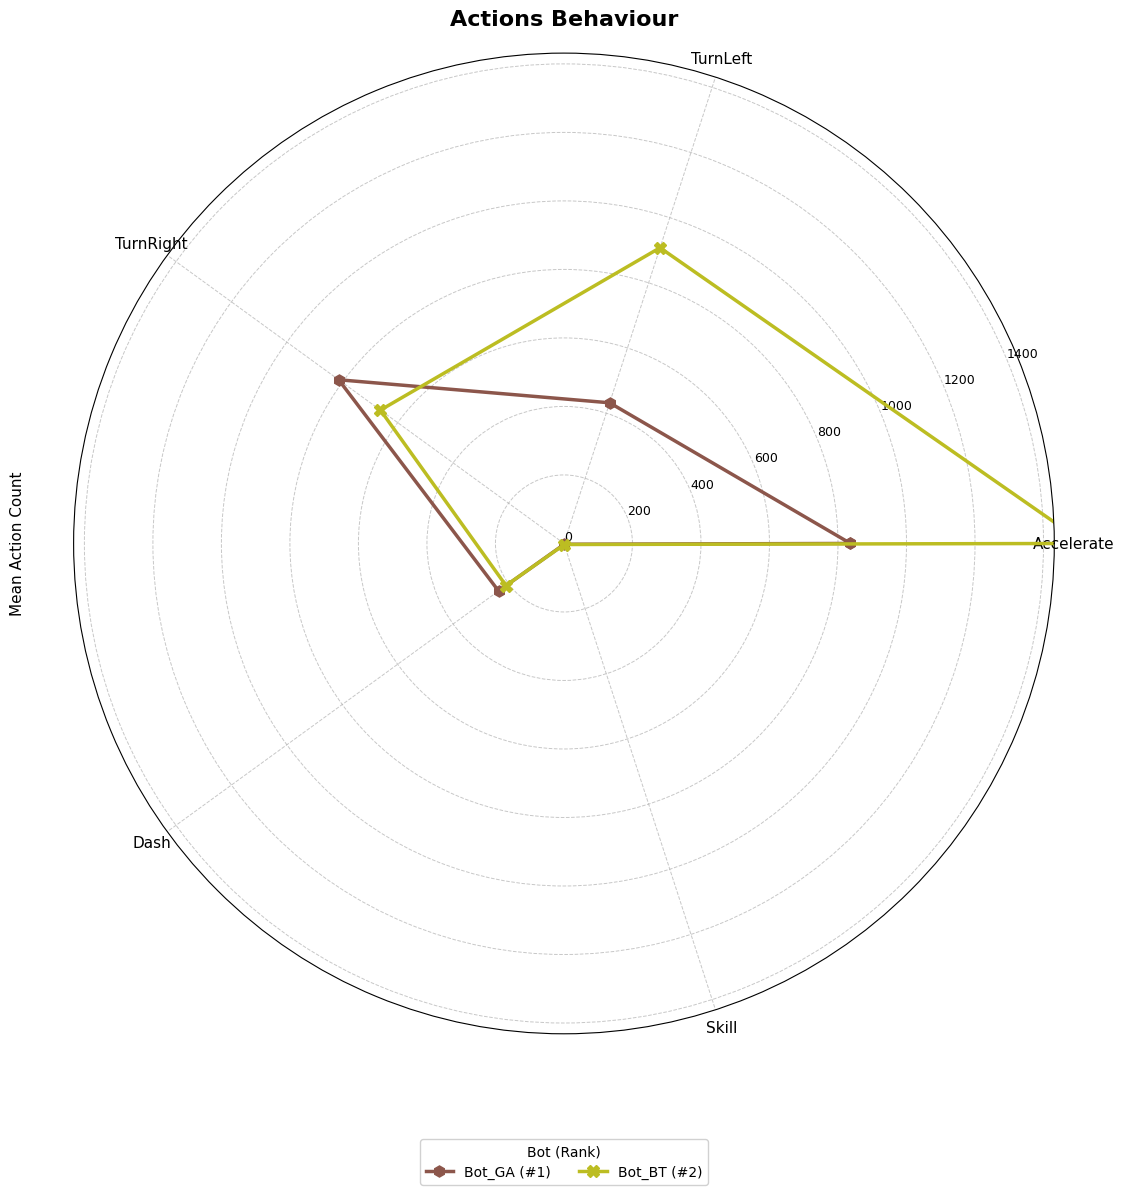

In [7]:
# Sample: aggregated action counts from both sides (Bot_L)
print(f"Sample: {len(df)} config-matchup pairs (all bots combined)")
fig = plot_action_radar(df)
plt.show()

#### Collision Behaviour
Hit/Struck/Tie distribution per bot

Sample: 8 config-matchup pairs (all bots combined)


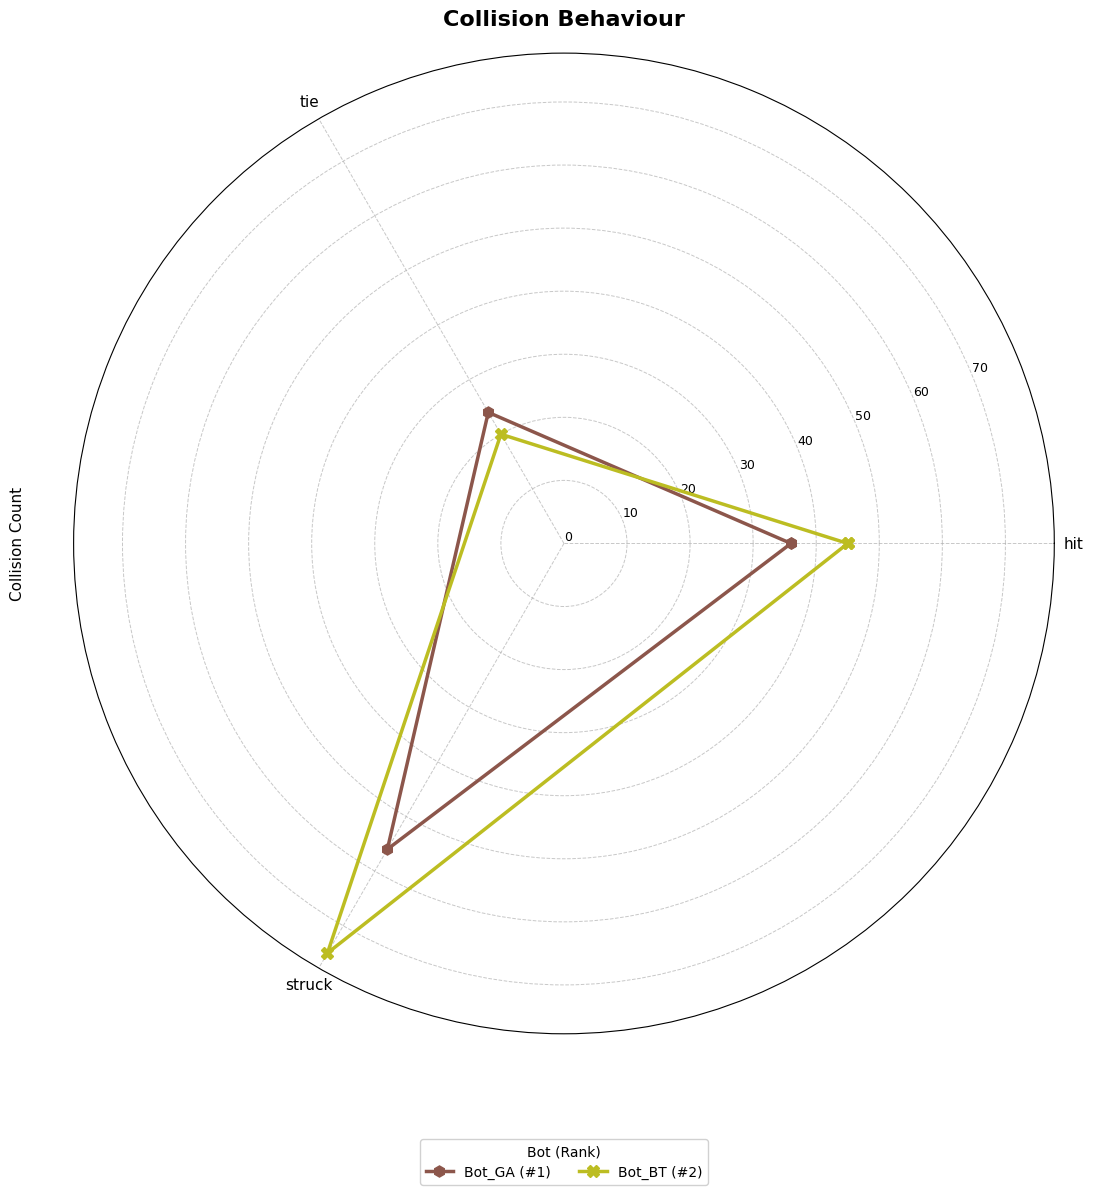

In [8]:
# Sample: aggregated collision counts from both sides (Bot_L)
print(f"Sample: {len(df)} config-matchup pairs (all bots combined)")
fig = plot_collision_radar(df)
plt.show()

### Win Rate Matrix

Shows how often each bot wins against others across different matchups.
This is calculated with taking mean of each configuration (10-games iteration matchup) resulting 240 games in total

2026-01-03 09:34:39.642 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-01-03 09:34:39.648 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:39.741 
  command:

    streamlit run /Users/defdef/Development/ml/anaconda3/envs/ml/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2026-01-03 09:34:39.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:39.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:39.742 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Sample: 8 config-matchup pairs → 2 unique matchups


2026-01-03 09:34:39.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:39.788 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:39.788 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


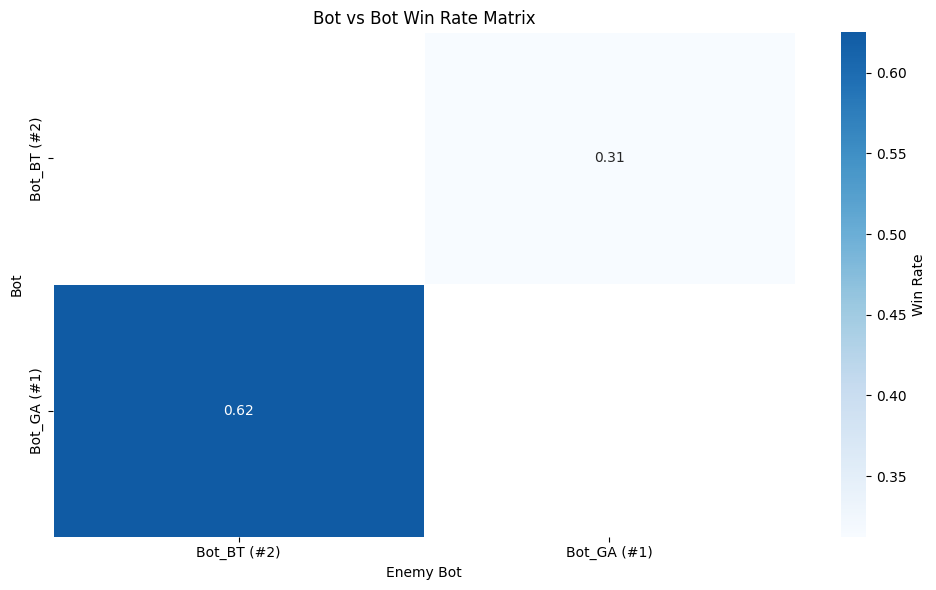

In [9]:
# Sample: mean winrate across all configurations per matchup
print(f"Sample: {len(df)} config-matchup pairs → {len(df.groupby(['Bot_L', 'Bot_R']))} unique matchups")
fig = plot_winrate_matrix(df, width, height)
plt.show()

### Action Taken (All Configurations)

Sample: 8 config-matchup pairs → 2 bots


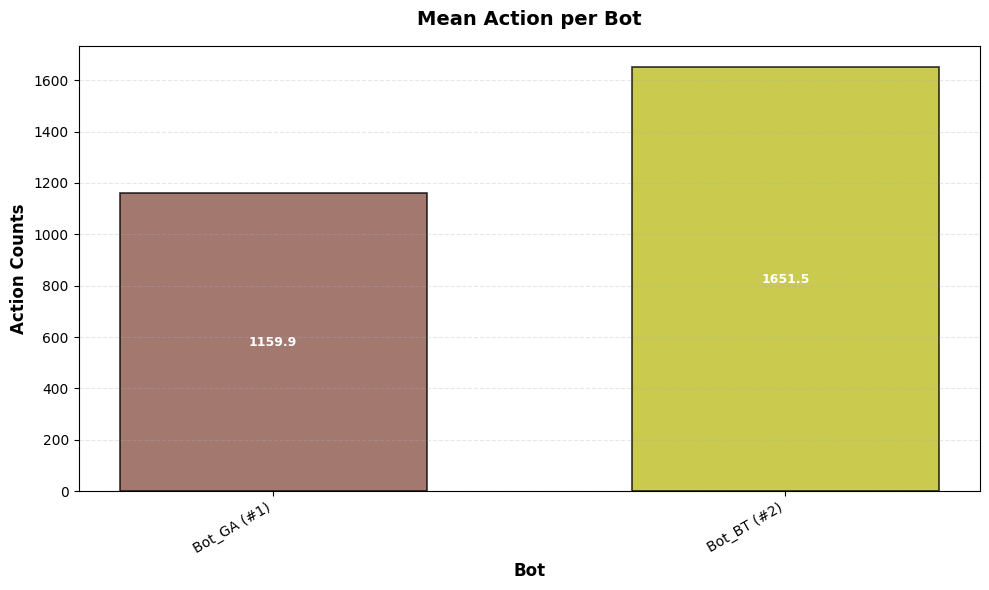

In [10]:
# Sample: mean action counts per bot across all configurations
print(f"Sample: {len(df)} config-matchup pairs → {len(df['Bot_L'].unique())} bots")
fig = plot_overall_bot_metrics(df, metric="ActionCounts_L", title="Mean Action per Bot")
plt.show()

### Action Duration (All Configurations)

Sample: 8 config-matchup pairs → 2 bots


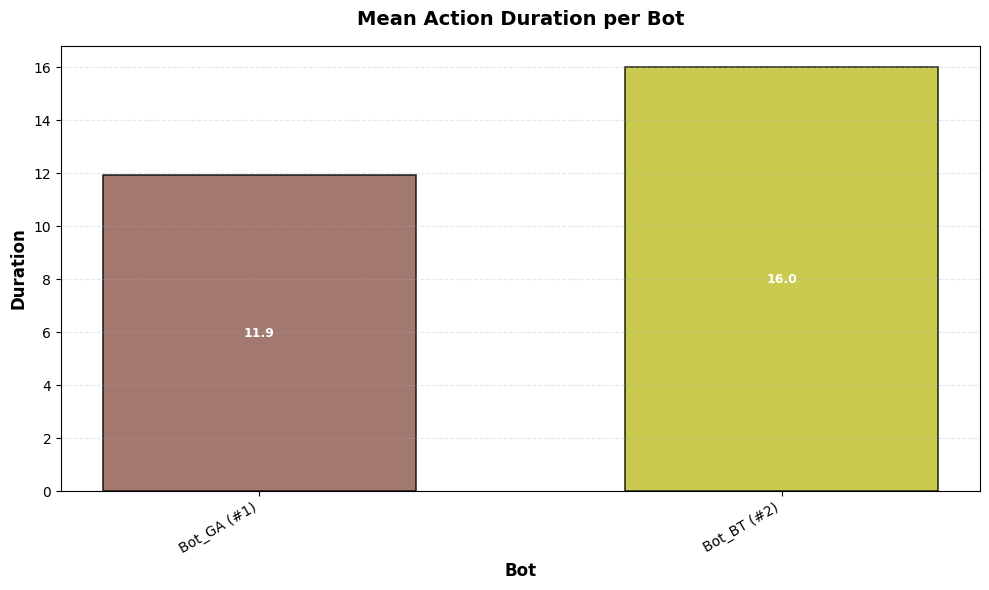

In [11]:
# Sample: mean action duration per bot across all configurations
print(f"Sample: {len(df)} config-matchup pairs → {len(df['Bot_L'].unique())} bots")
fig = plot_overall_bot_metrics(df, metric="Duration_L", title="Mean Action Duration per Bot")
plt.show()

### Collision (All Configurations)

Sample: 8 config-matchup pairs → 2 bots


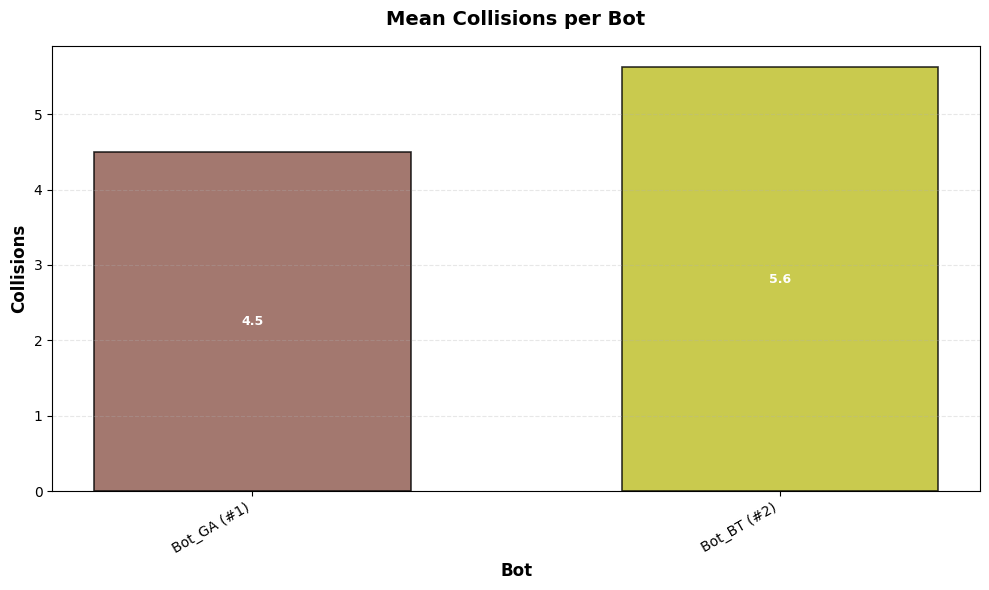

In [12]:
# Sample: mean collisions per bot across all configurations
print(f"Sample: {len(df)} config-matchup pairs → {len(df['Bot_L'].unique())} bots")
fig = plot_overall_bot_metrics(df, metric="Collisions_L", title="Mean Collisions per Bot")
plt.show()

### Match Duration (All Configurations)

Sample: 8 config-matchup pairs → 2 bots


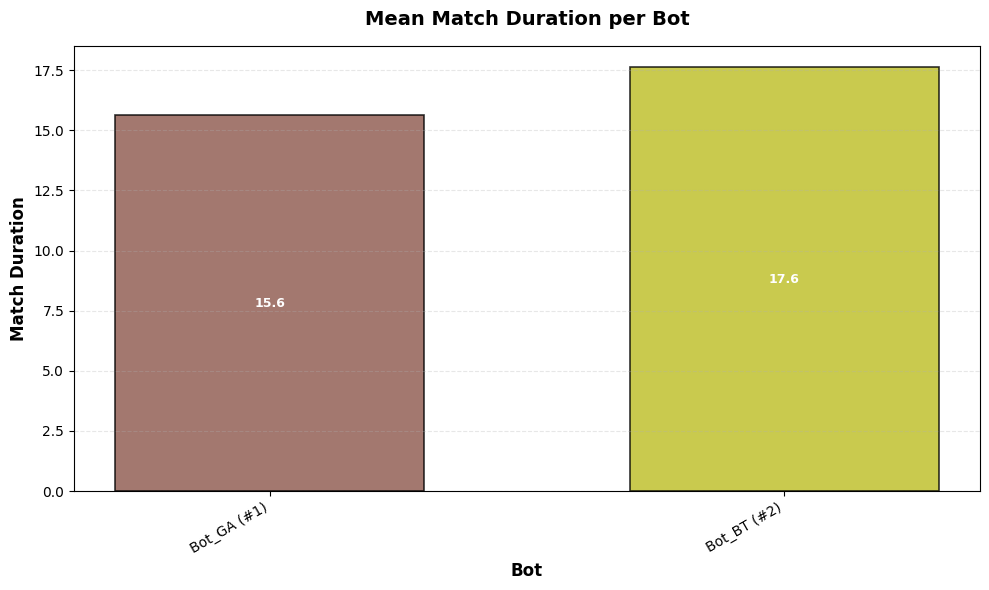

In [13]:
# Sample: mean match duration per bot across all configurations
print(f"Sample: {len(df)} config-matchup pairs → {len(df['Bot_L'].unique())} bots")
fig = plot_overall_bot_metrics(df, metric="MatchDur", title="Mean Match Duration per Bot")
plt.show()

### Win Rate Grouped by Timer

Sample: 8 config-matchup pairs → 4 (Timer × Bot) groups


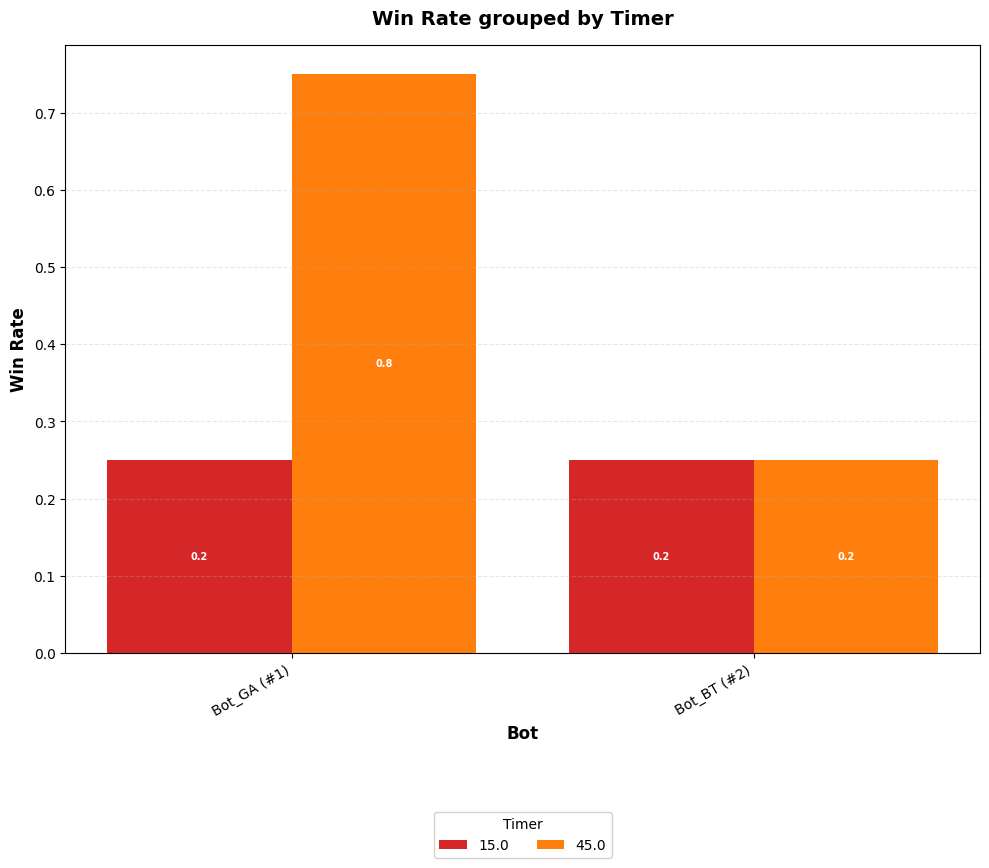

In [14]:
# Sample: winrate grouped by Timer
timer_groups = df.groupby(['Timer', 'Bot_L']).size()
print(f"Sample: {len(df)} config-matchup pairs → {len(timer_groups)} (Timer × Bot) groups")
fig = plot_grouped_config_winrates(df, config_col="Timer")
plt.show()

### Win Rate Grouped by Action Interval

Sample: 8 config-matchup pairs → 2 (ActInterval × Bot) groups


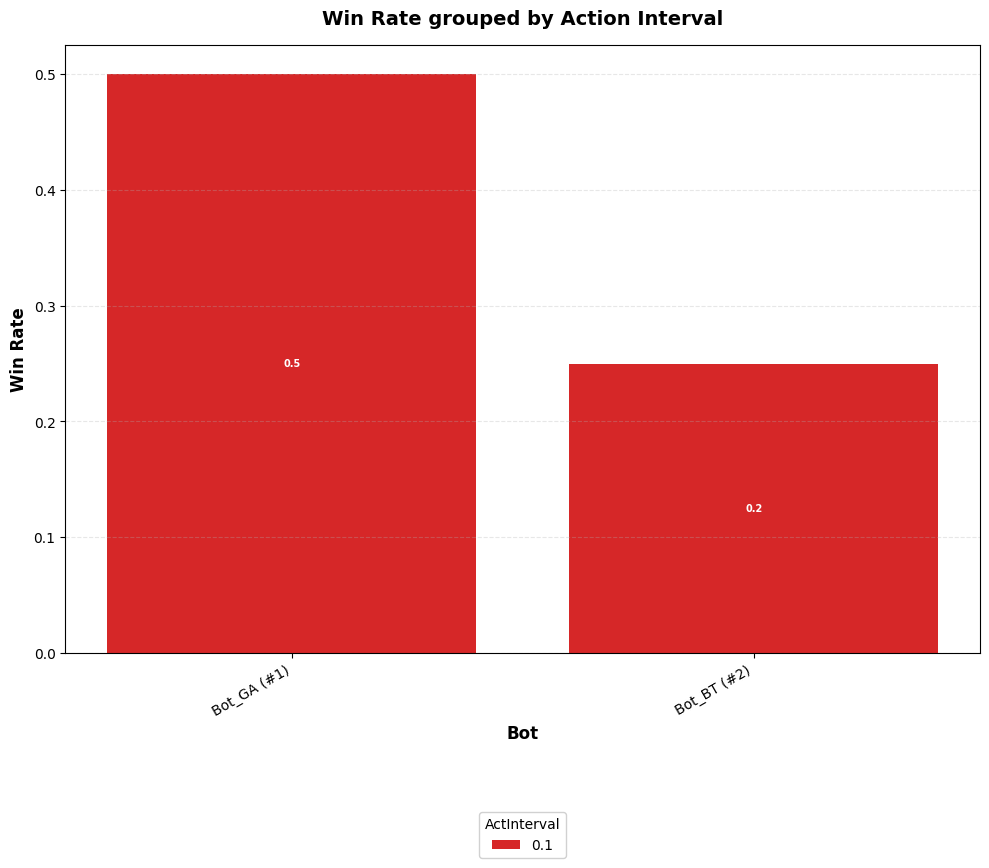

In [15]:
# Sample: winrate grouped by ActInterval
actint_groups = df.groupby(['ActInterval', 'Bot_L']).size()
print(f"Sample: {len(df)} config-matchup pairs → {len(actint_groups)} (ActInterval × Bot) groups")
fig = plot_grouped_config_winrates(df, config_col="ActInterval")
plt.show()

### Win Rate Grouped by Round

Sample: 8 config-matchup pairs → 4 (Round × Bot) groups


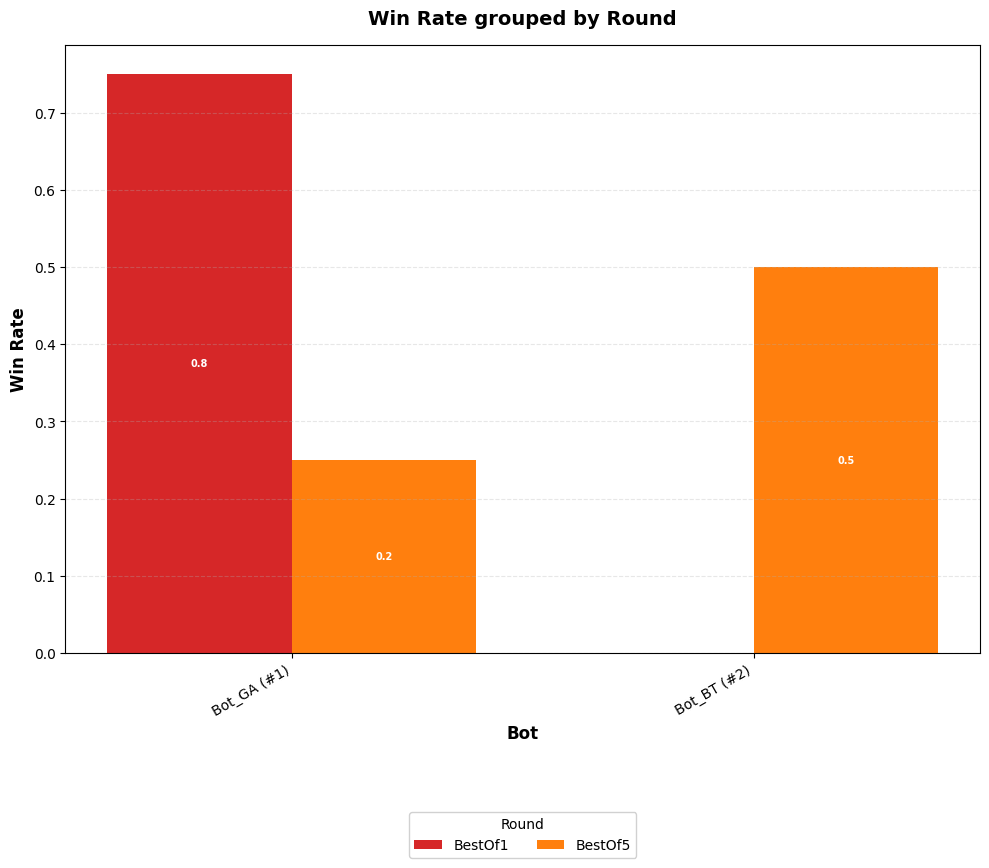

In [16]:
# Sample: winrate grouped by Round
round_groups = df.groupby(['Round', 'Bot_L']).size()
print(f"Sample: {len(df)} config-matchup pairs → {len(round_groups)} (Round × Bot) groups")
fig = plot_grouped_config_winrates(df, config_col="Round")
plt.show()

### Win Rate Grouped by Skill

Sample: 8 config-matchup pairs → 2 (Skill × Bot) groups


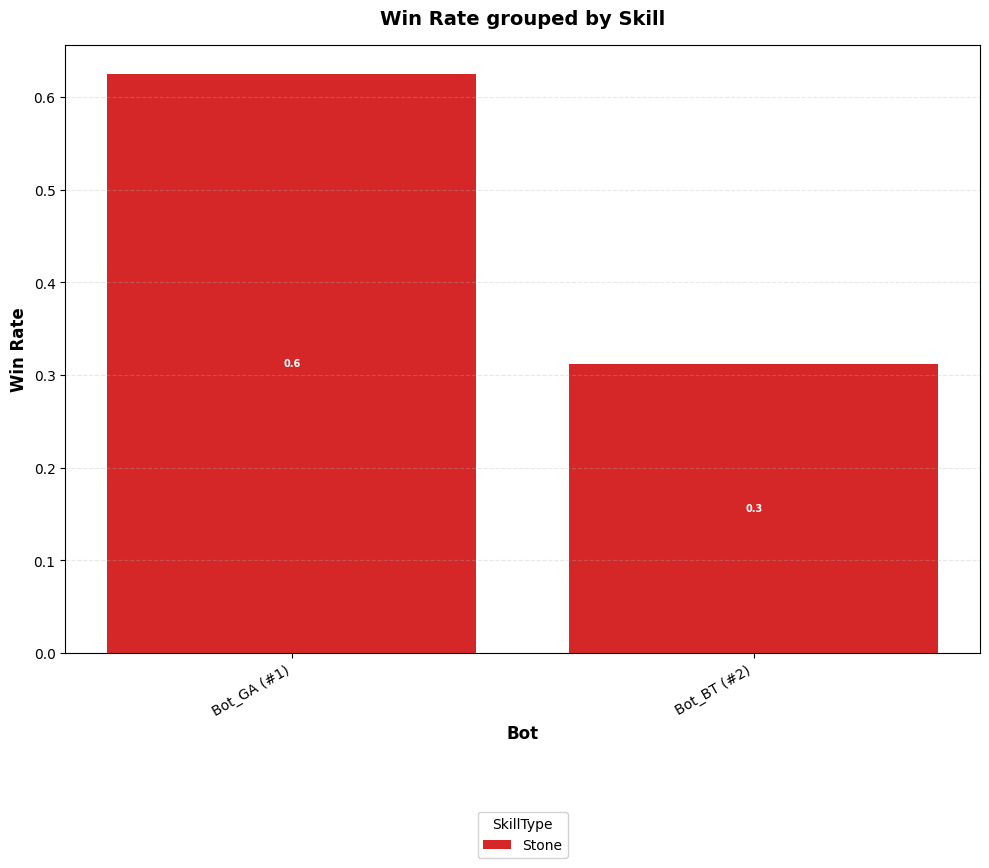

In [17]:
# Sample: winrate grouped by Skill (SkillLeft)
skill_groups = df.groupby(['SkillLeft', 'Bot_L']).size()
print(f"Sample: {len(df)} config-matchup pairs → {len(skill_groups)} (Skill × Bot) groups")
fig = plot_grouped_config_winrates(df, config_col="Skill")
plt.show()

### Collision Grouped by Timer

Sample: 8 config-matchup pairs → 4 (Timer × Bot) groups


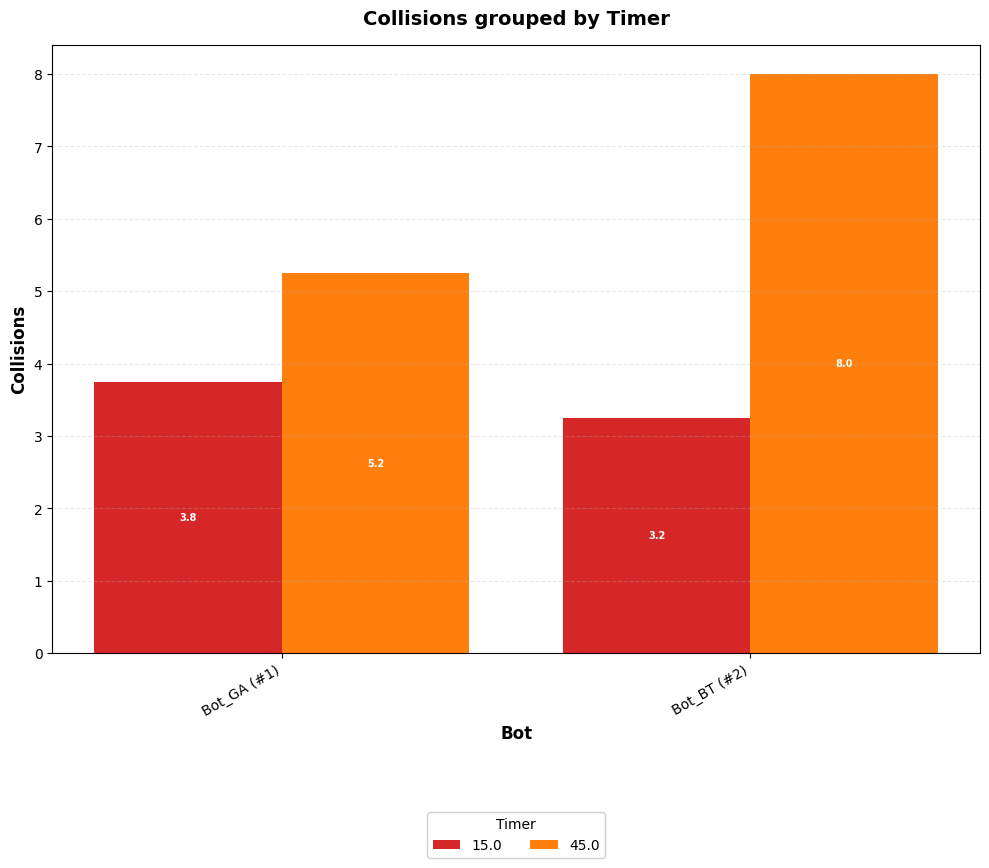

In [18]:
# Sample: collisions grouped by Timer
print(f"Sample: {len(df)} config-matchup pairs → {len(timer_groups)} (Timer × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Timer")
plt.show()

### Collision Grouped by Action Interval

Sample: 8 config-matchup pairs → 2 (ActInterval × Bot) groups


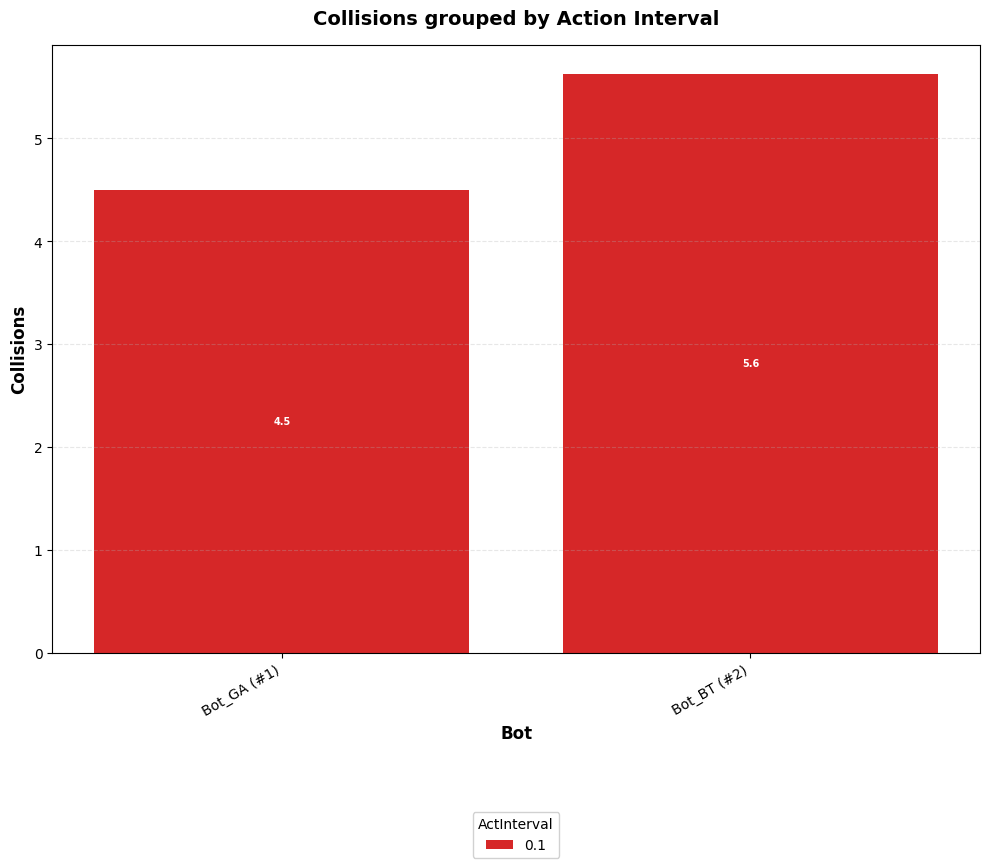

In [19]:
# Sample: collisions grouped by ActInterval
print(f"Sample: {len(df)} config-matchup pairs → {len(actint_groups)} (ActInterval × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="ActInterval")
plt.show()

### Collision Grouped by Round

Sample: 8 config-matchup pairs → 4 (Round × Bot) groups


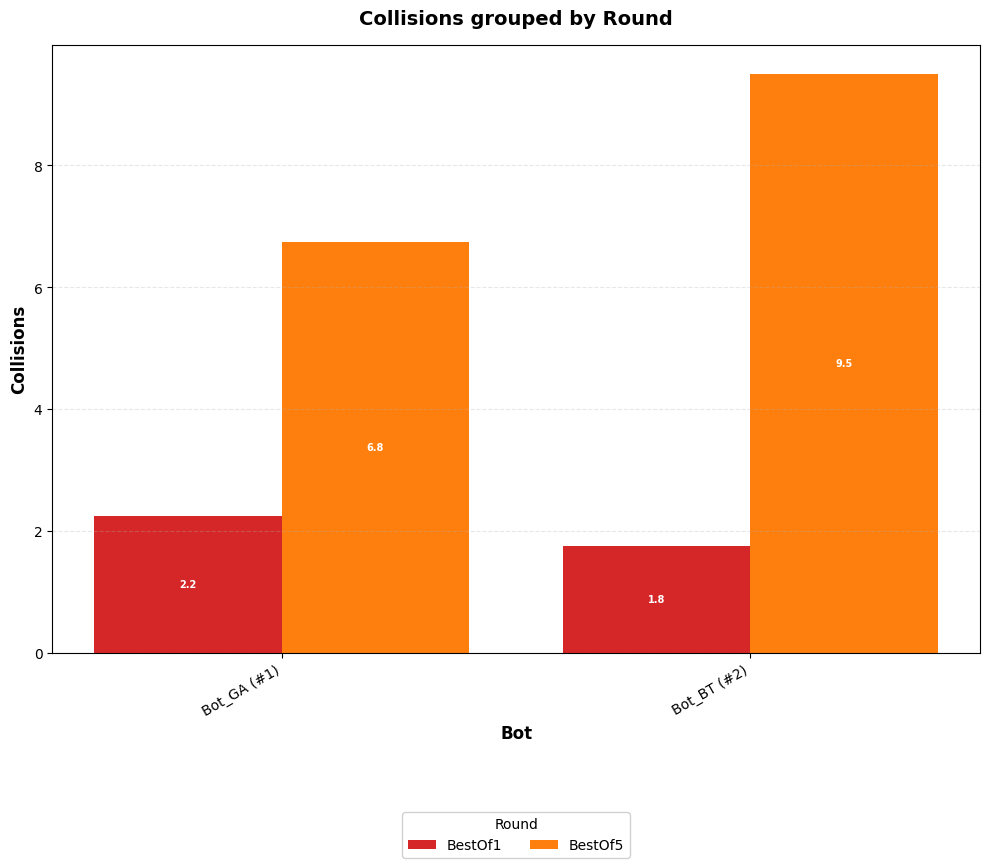

In [20]:
# Sample: collisions grouped by Round
print(f"Sample: {len(df)} config-matchup pairs → {len(round_groups)} (Round × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Round")
plt.show()

### Collision Grouped by Skill

Sample: 8 config-matchup pairs → 2 (Skill × Bot) groups


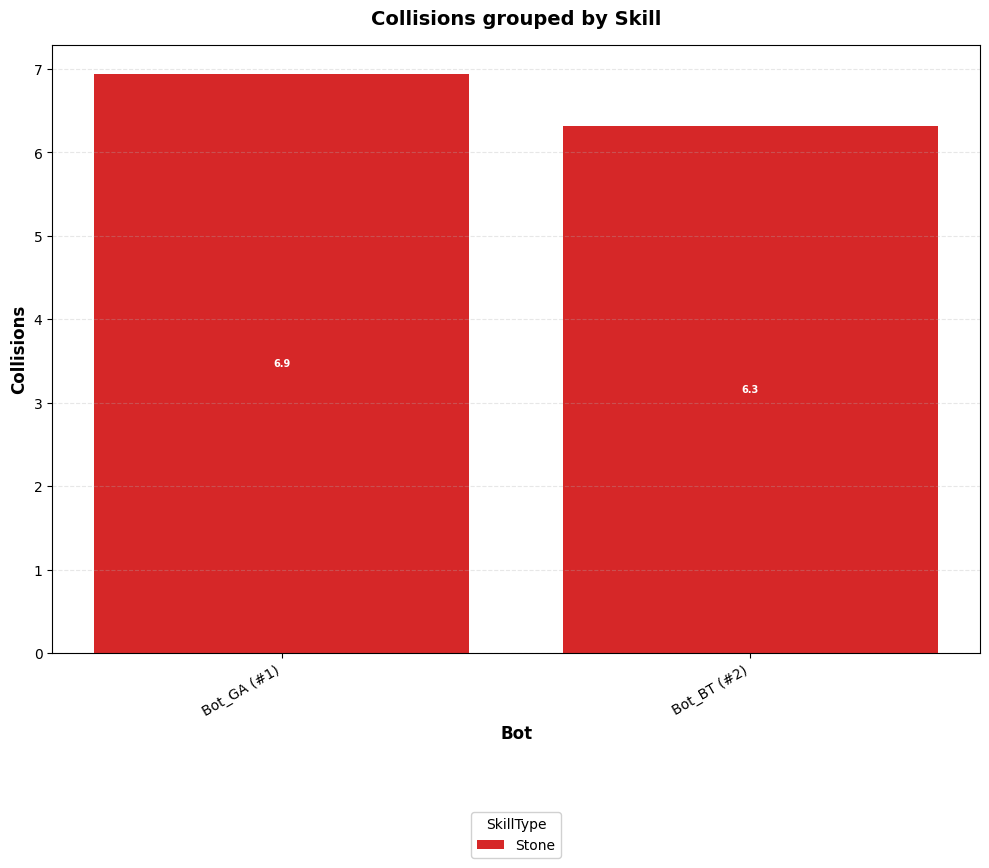

In [21]:
# Sample: collisions grouped by Skill
print(f"Sample: {len(df)} config-matchup pairs → {len(skill_groups)} (Skill × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="Collisions_L", config_col="Skill")
plt.show()

### Action Taken Grouped by Timer

Sample: 8 config-matchup pairs → 4 (Timer × Bot) groups


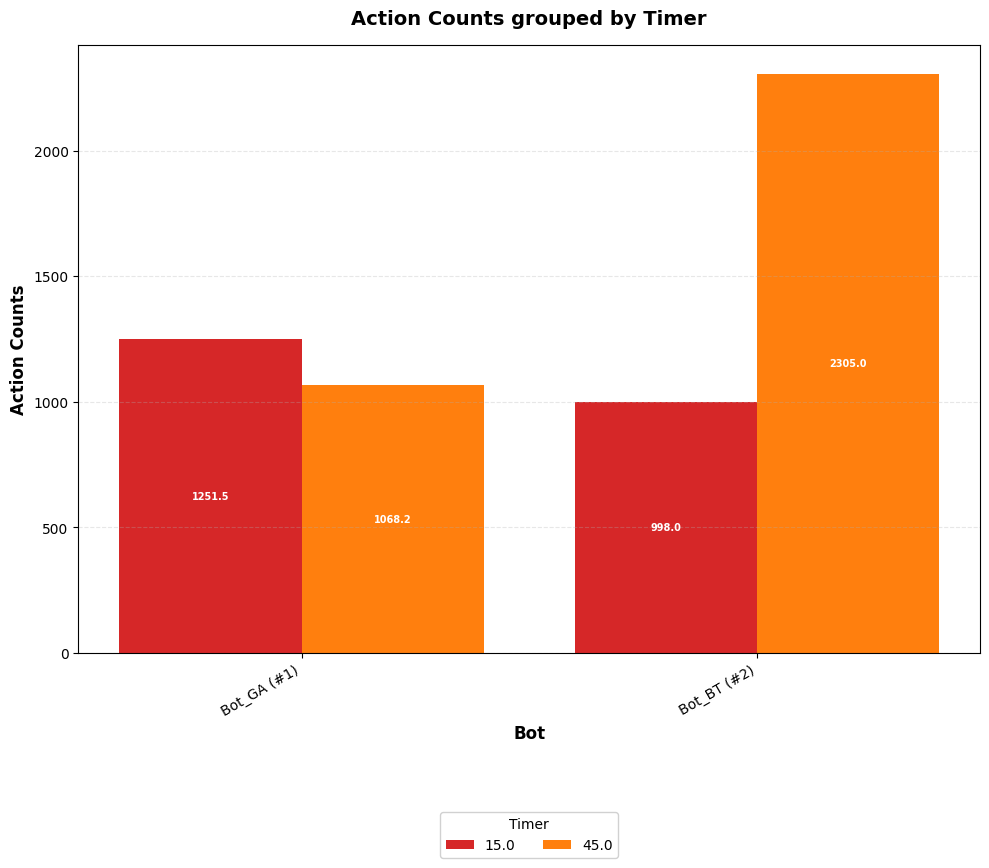

In [22]:
# Sample: action counts grouped by Timer
print(f"Sample: {len(df)} config-matchup pairs → {len(timer_groups)} (Timer × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Timer")
plt.show()

### Action Taken Grouped by Action Interval

Sample: 8 config-matchup pairs → 2 (ActInterval × Bot) groups


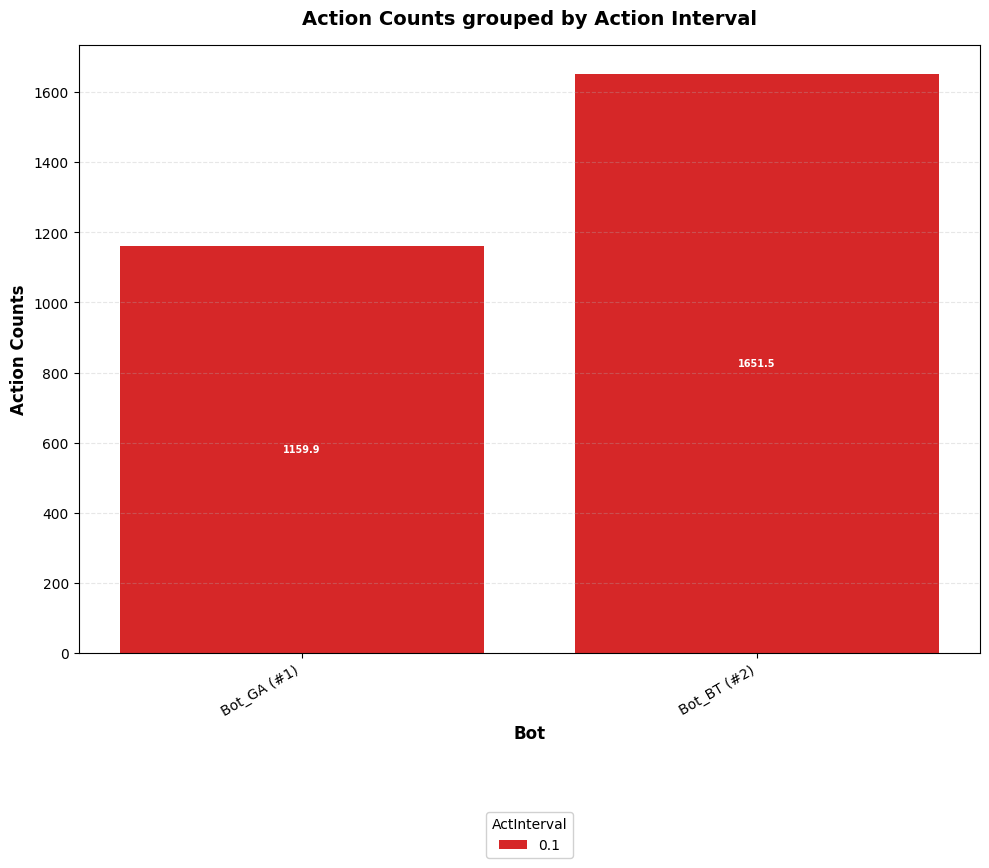

In [23]:
# Sample: action counts grouped by ActInterval
print(f"Sample: {len(df)} config-matchup pairs → {len(actint_groups)} (ActInterval × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="ActInterval")
plt.show()

### Action Taken Grouped by Round

Sample: 8 config-matchup pairs → 4 (Round × Bot) groups


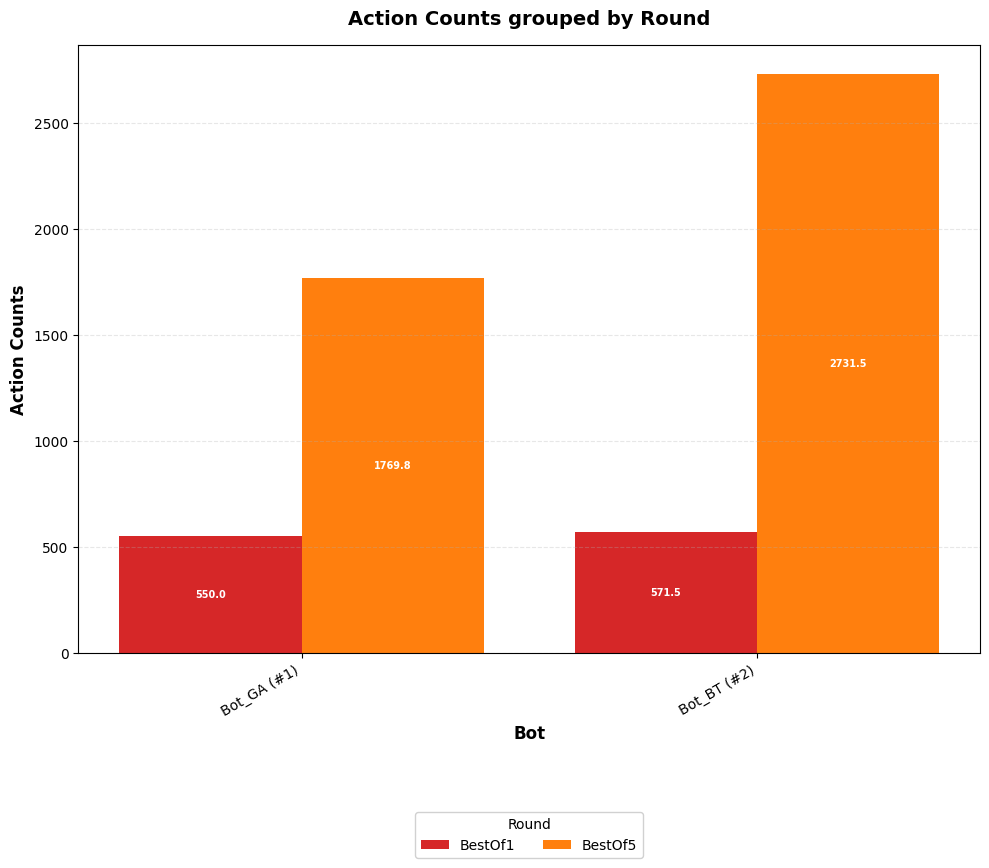

In [24]:
# Sample: action counts grouped by Round
print(f"Sample: {len(df)} config-matchup pairs → {len(round_groups)} (Round × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Round")
plt.show()

### Action Taken Grouped by Skill

Sample: 8 config-matchup pairs → 2 (Skill × Bot) groups


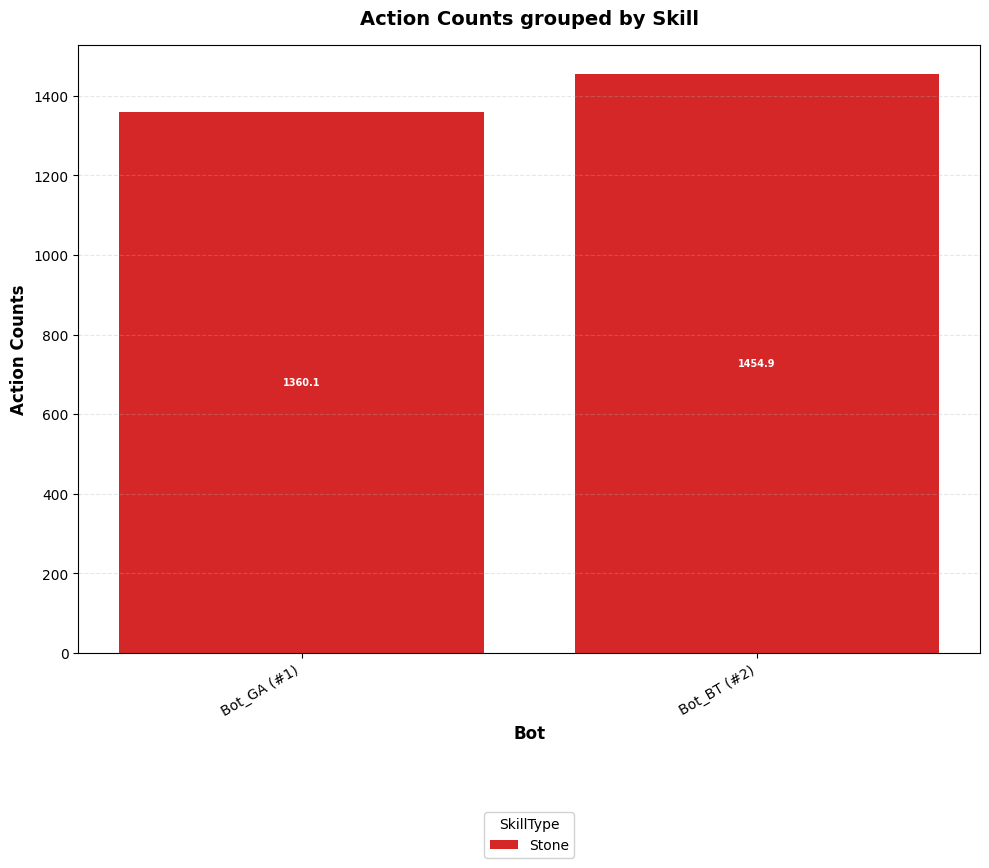

In [25]:
# Sample: action counts grouped by Skill
print(f"Sample: {len(df)} config-matchup pairs → {len(skill_groups)} (Skill × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="ActionCounts_L", config_col="Skill")
plt.show()

### Action Duration Grouped by Timer

Sample: 8 config-matchup pairs → 4 (Timer × Bot) groups


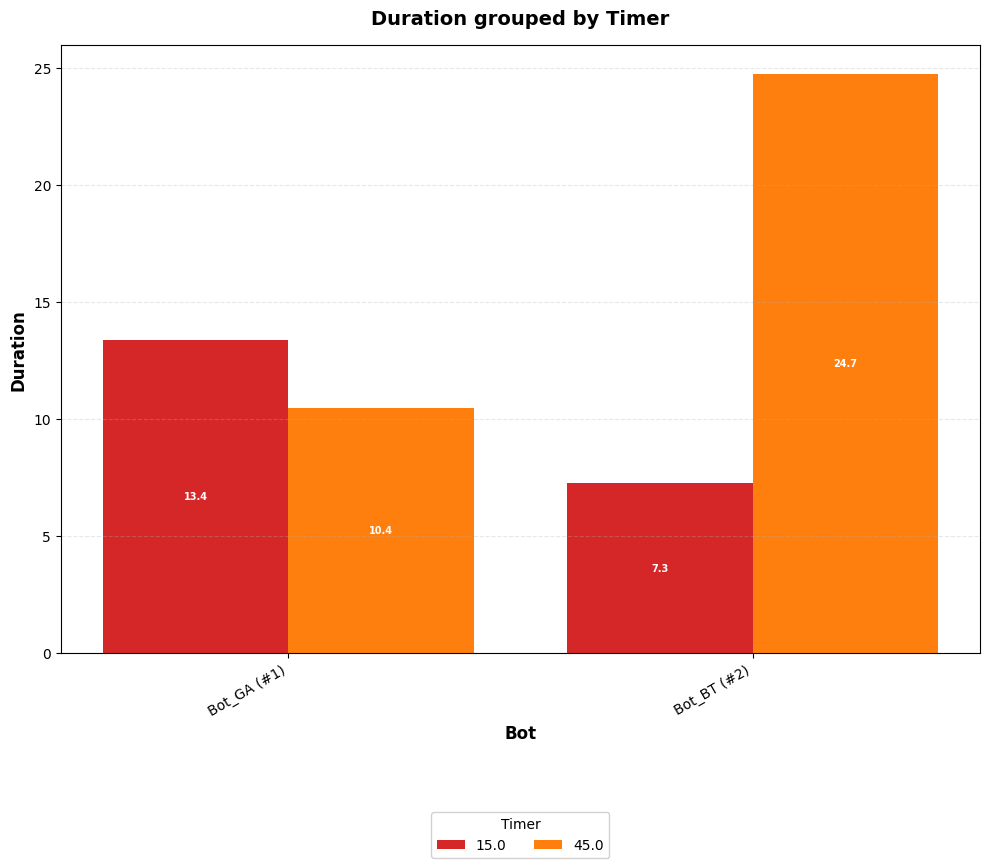

In [26]:
# Sample: action duration grouped by Timer
print(f"Sample: {len(df)} config-matchup pairs → {len(timer_groups)} (Timer × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Timer")
plt.show()

### Action Duration Grouped by Action Interval

Sample: 8 config-matchup pairs → 2 (ActInterval × Bot) groups


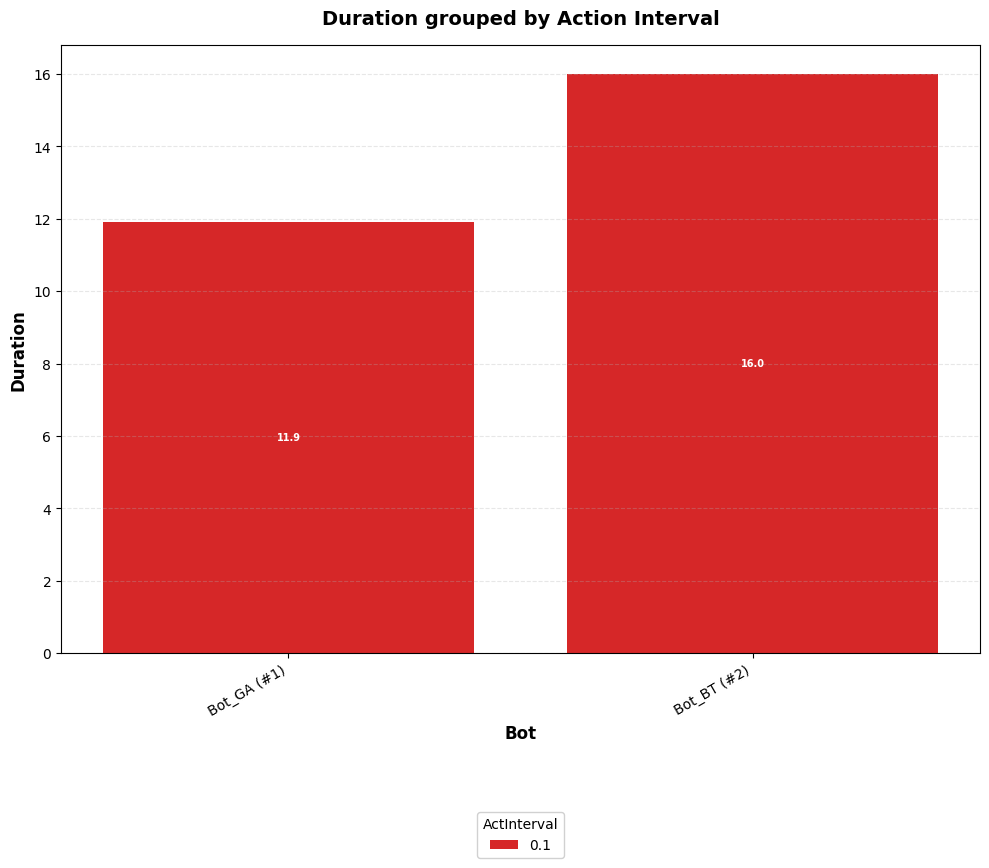

In [27]:
# Sample: action duration grouped by ActInterval
print(f"Sample: {len(df)} config-matchup pairs → {len(actint_groups)} (ActInterval × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="ActInterval")
plt.show()

### Action Duration Grouped by Round

Sample: 8 config-matchup pairs → 4 (Round × Bot) groups


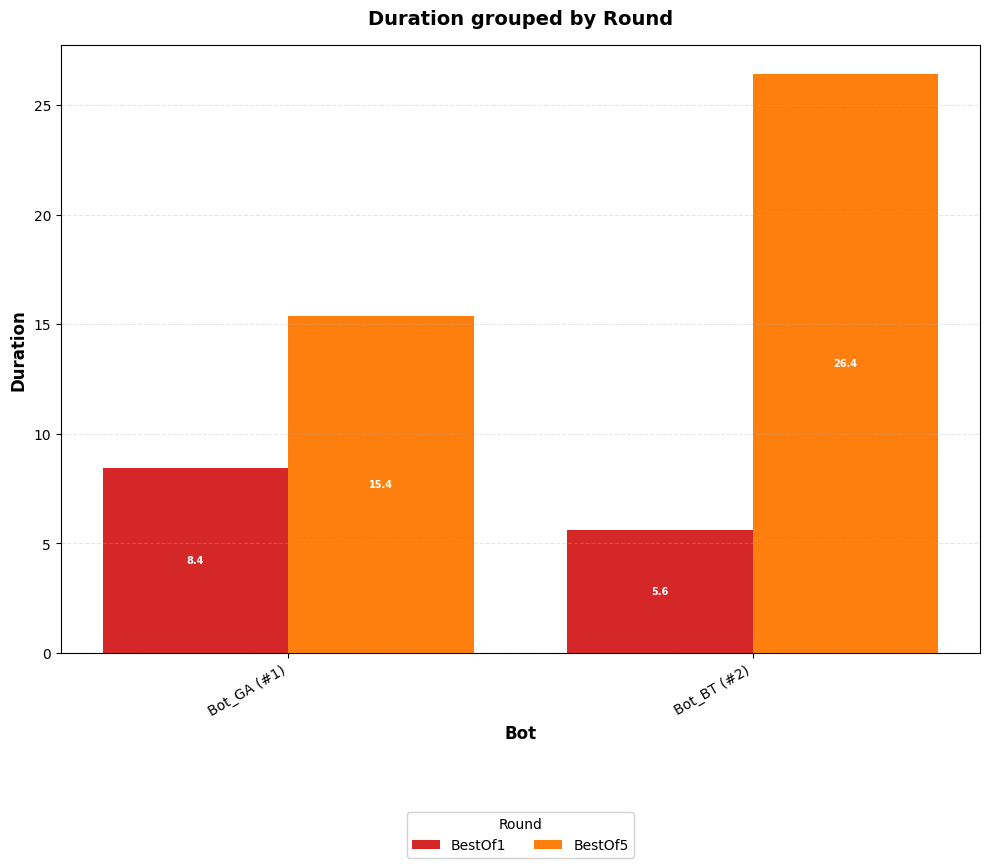

In [28]:
# Sample: action duration grouped by Round
print(f"Sample: {len(df)} config-matchup pairs → {len(round_groups)} (Round × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Round")
plt.show()

### Action Duration Grouped by Skill

Sample: 8 config-matchup pairs → 2 (Skill × Bot) groups


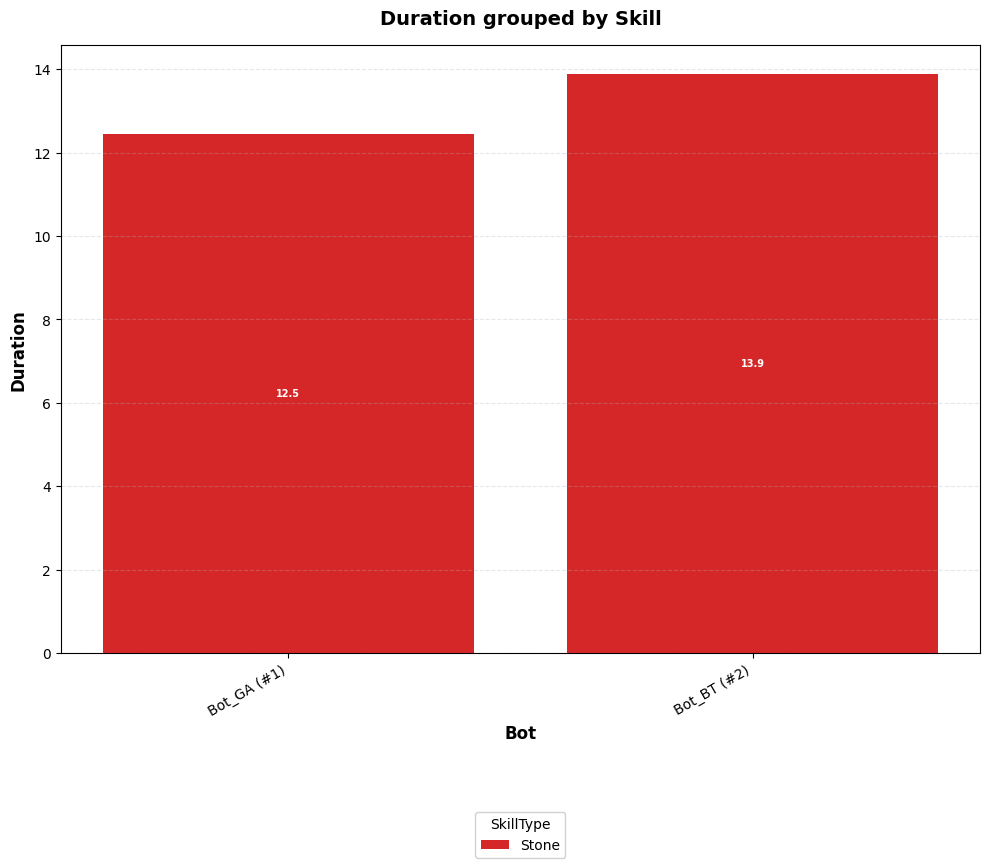

In [29]:
# Sample: action duration grouped by Skill
print(f"Sample: {len(df)} config-matchup pairs → {len(skill_groups)} (Skill × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="Duration_L", config_col="Skill")
plt.show()

### Match Duration Grouped by Timer

Sample: 8 config-matchup pairs → 4 (Timer × Bot) groups


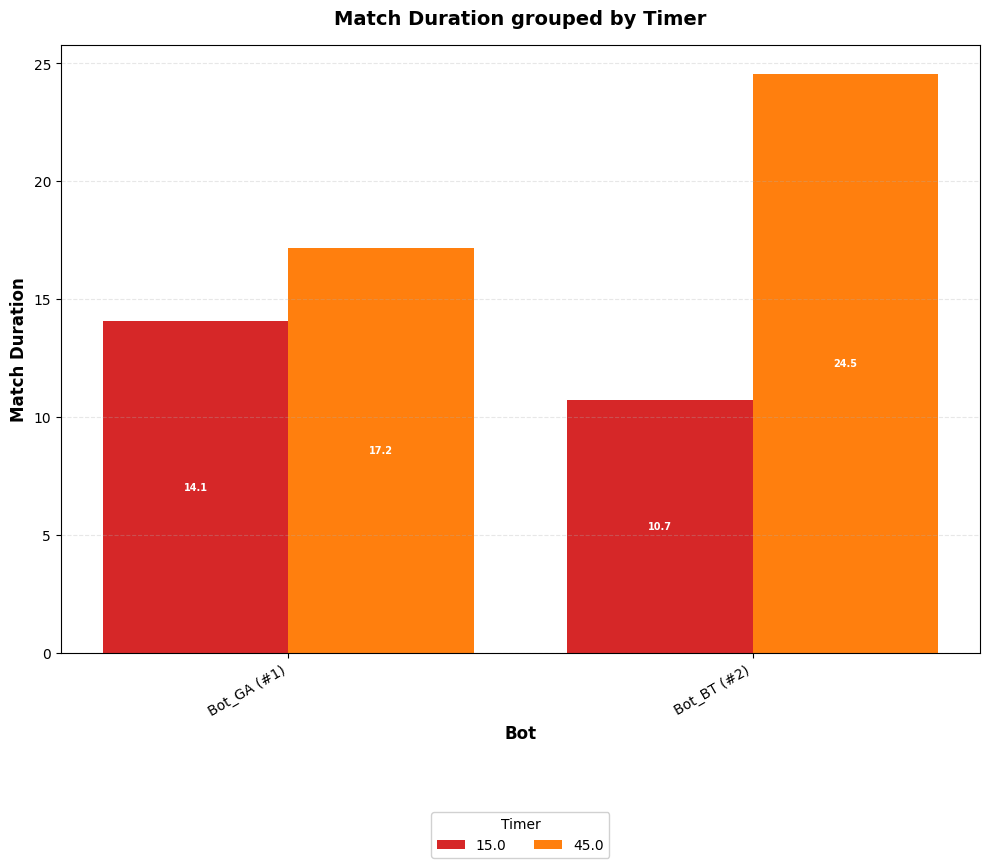

In [30]:
# Sample: match duration grouped by Timer
print(f"Sample: {len(df)} config-matchup pairs → {len(timer_groups)} (Timer × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Timer")
plt.show()

### Match Duration Grouped by Action Interval

Sample: 8 config-matchup pairs → 2 (ActInterval × Bot) groups


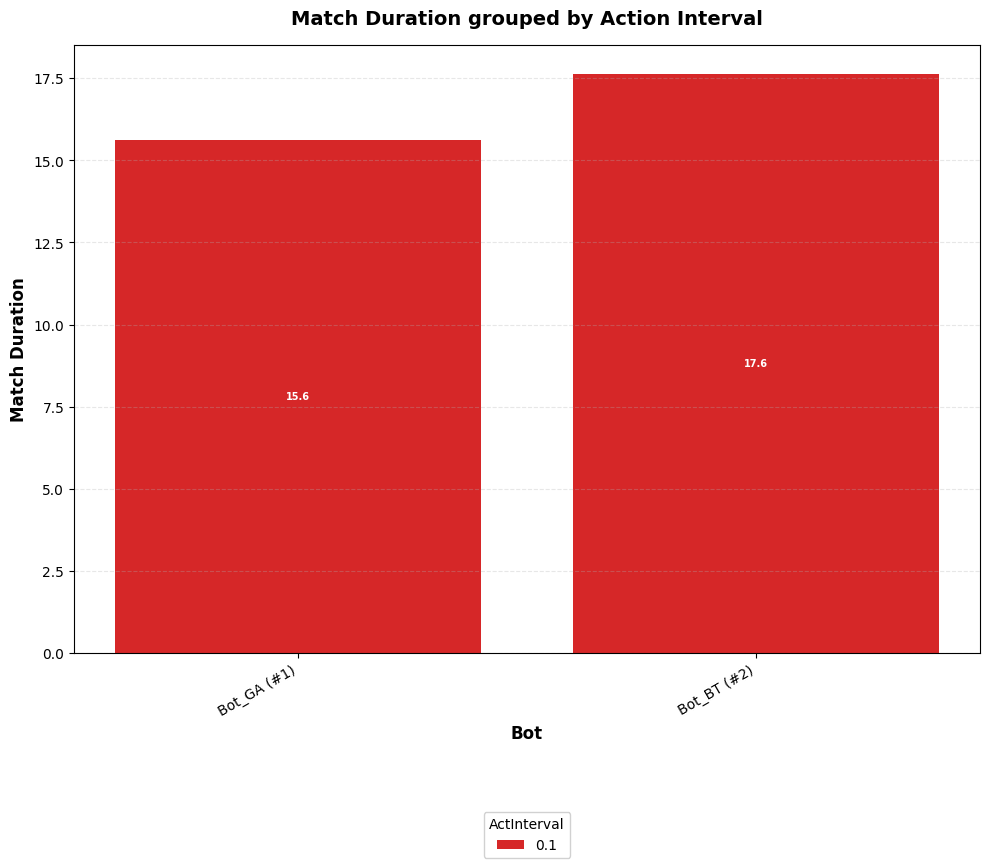

In [31]:
# Sample: match duration grouped by ActInterval
print(f"Sample: {len(df)} config-matchup pairs → {len(actint_groups)} (ActInterval × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="ActInterval")
plt.show()

### Match Duration Grouped by Round

Sample: 8 config-matchup pairs → 4 (Round × Bot) groups


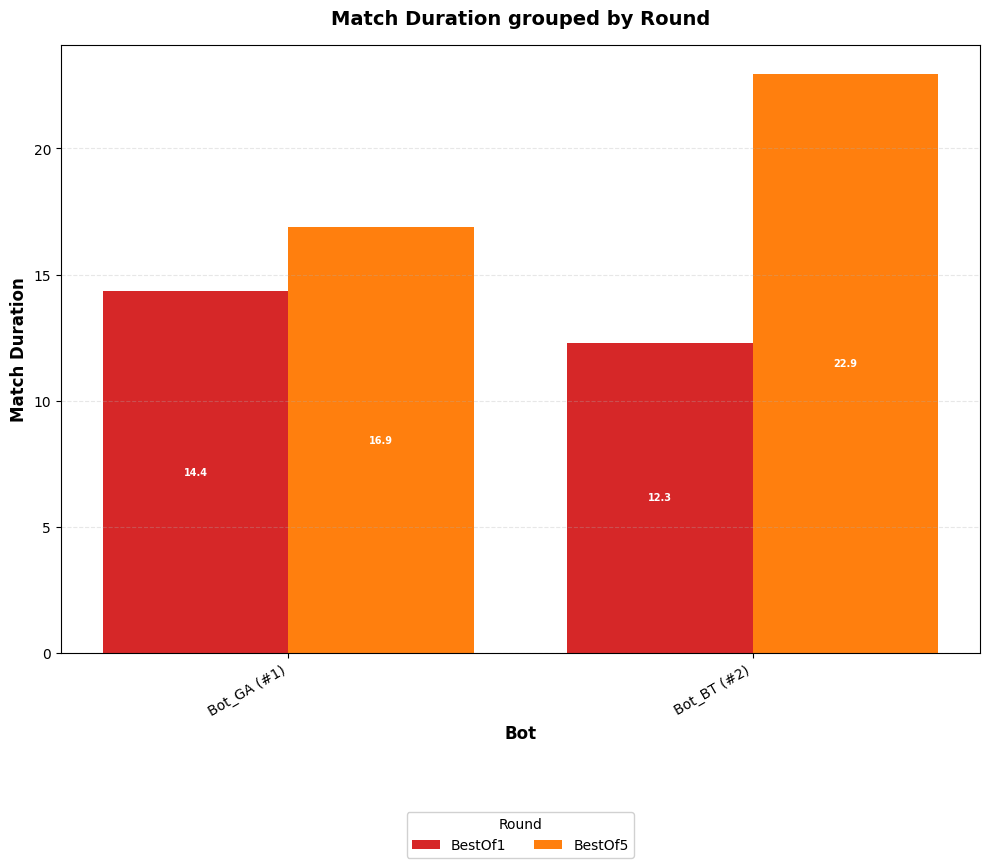

In [32]:
# Sample: match duration grouped by Round
print(f"Sample: {len(df)} config-matchup pairs → {len(round_groups)} (Round × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Round")
plt.show()

### Match Duration Grouped by Skill

Sample: 8 config-matchup pairs → 2 (Skill × Bot) groups


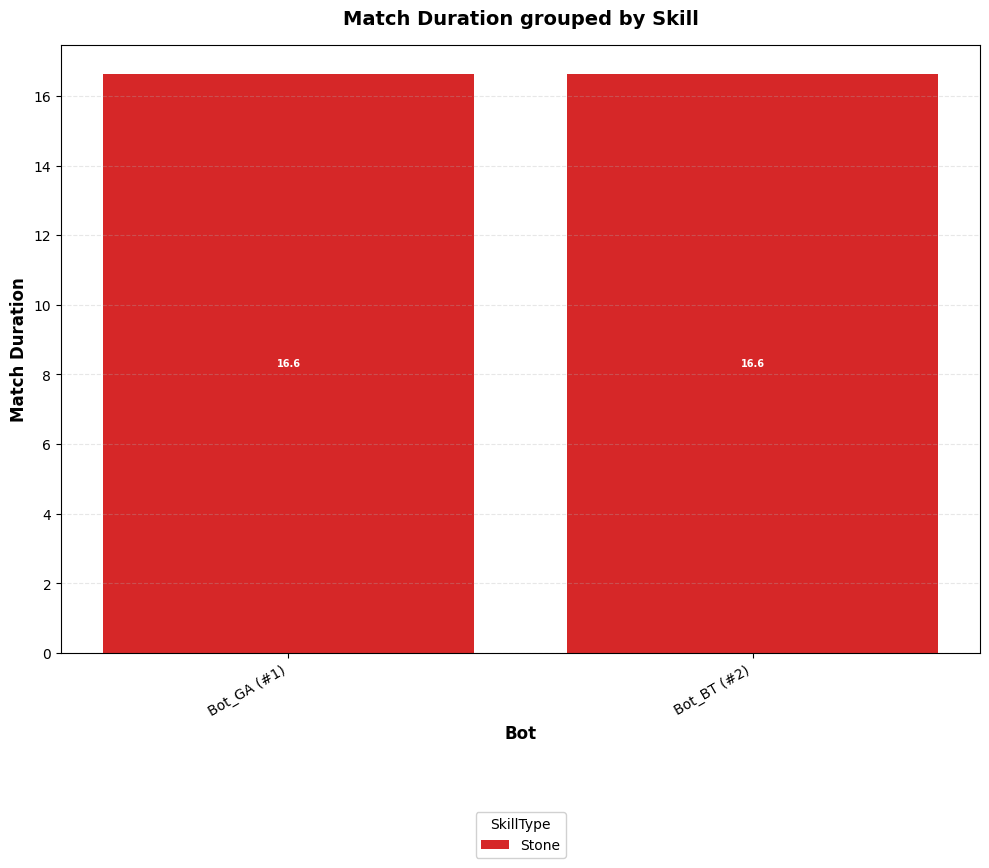

In [33]:
# Sample: match duration grouped by Skill
print(f"Sample: {len(df)} config-matchup pairs → {len(skill_groups)} (Skill × Bot) groups")
fig = plot_grouped_config_winrates(df, metric="MatchDur", config_col="Skill")
plt.show()

### Time-Related Trends

Analyzes Bots aggressiveness over game duration with determining how much action taken duration related to the overall game duration (Time Setting).
Higher timers don't always lead to longer matches. Some matchups finish fights early regardless of time limit.

2026-01-03 09:34:41.459 No runtime found, using MemoryCacheStorageManager
2026-01-03 09:34:41.463 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:41.463 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:41.463 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:41.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Sample: 8 config-matchup pairs → 4 (Timer × ActInterval × Bot) groups


2026-01-03 09:34:41.541 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:41.541 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:41.541 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


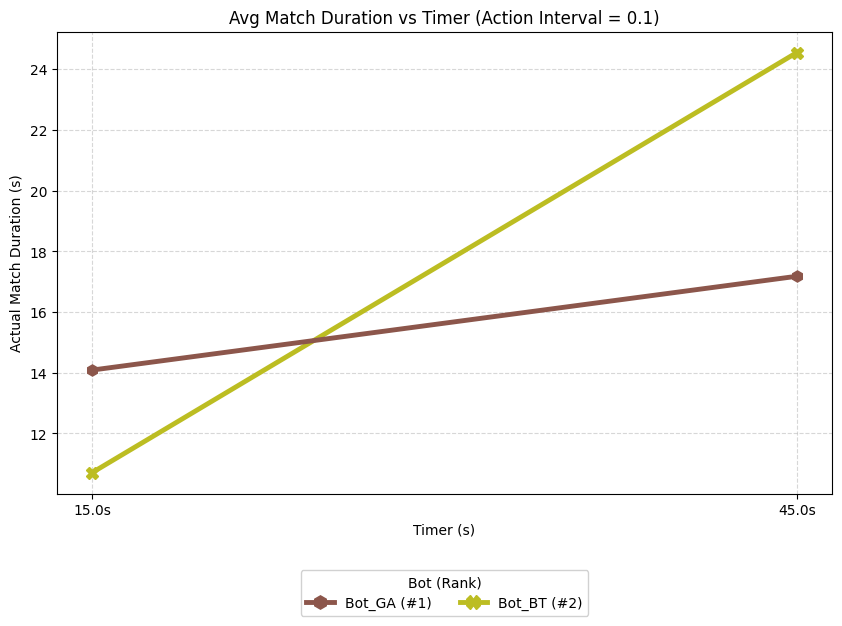

In [34]:
# Sample: match duration vs bot action duration (Timer × ActInterval × Bot groups)
time_groups = df.groupby(['Timer', 'ActInterval', 'Bot_L']).size()
print(f"Sample: {len(df)} config-matchup pairs → {len(time_groups)} (Timer × ActInterval × Bot) groups")
figs = plot_time_related(df, width, height)
for fig in figs:
    plt.show()

### Action Distribution per Bots

Sample: 8 config-matchup pairs → 2 bots


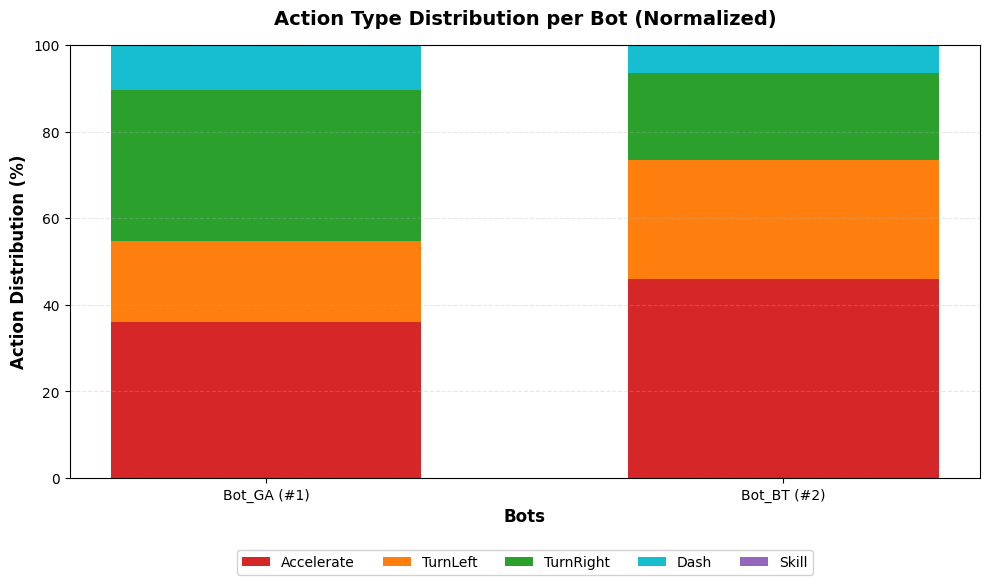

In [35]:
# Sample: action type distribution per bot (all configurations aggregated)
print(f"Sample: {len(df)} config-matchup pairs → {len(df['Bot_L'].unique())} bots")
fig = plot_action_distribution_stacked(df, normalize=True)
plt.show()

### Action Intensity Over Time (Per Configuration)

Shows action intensity over time for different timer and action interval configurations


--- Timer=15.0, ActionInterval=0.1 ---
Sample: 80 timebin records


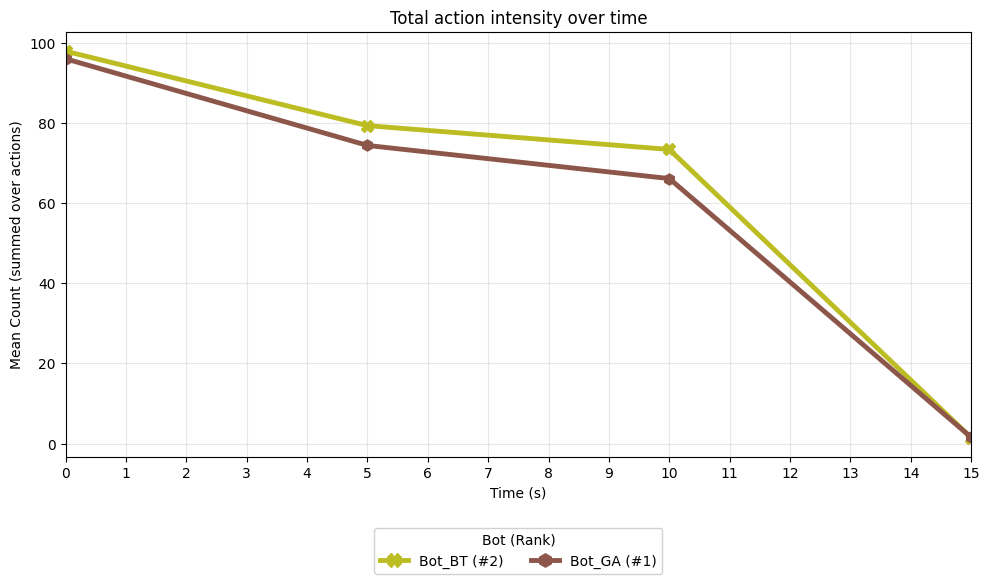

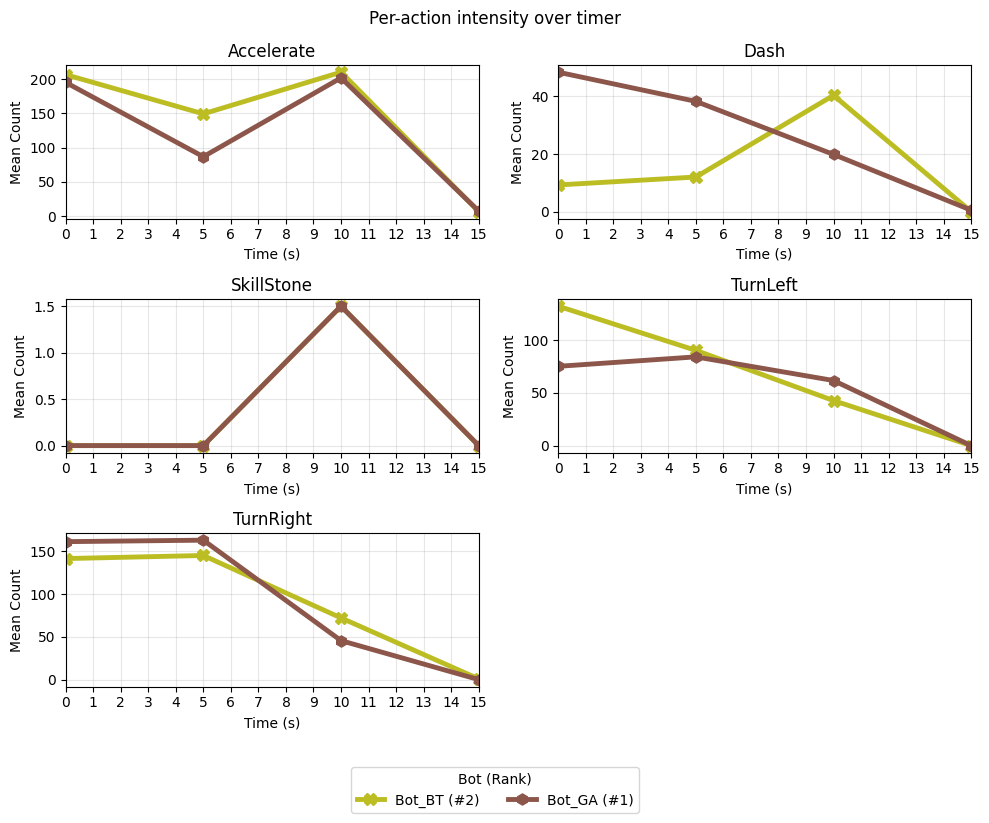


--- Timer=45.0, ActionInterval=0.1 ---
Sample: 150 timebin records


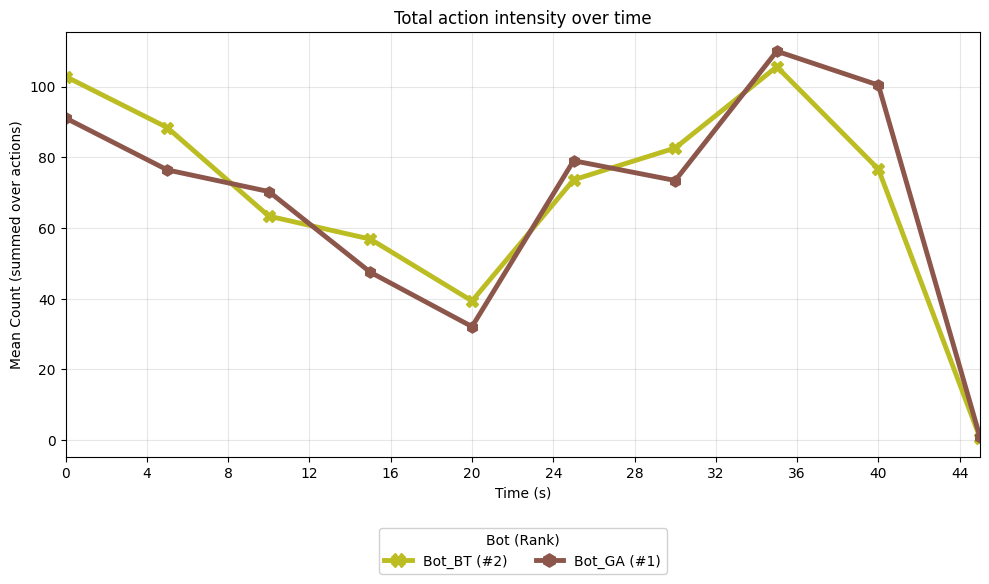

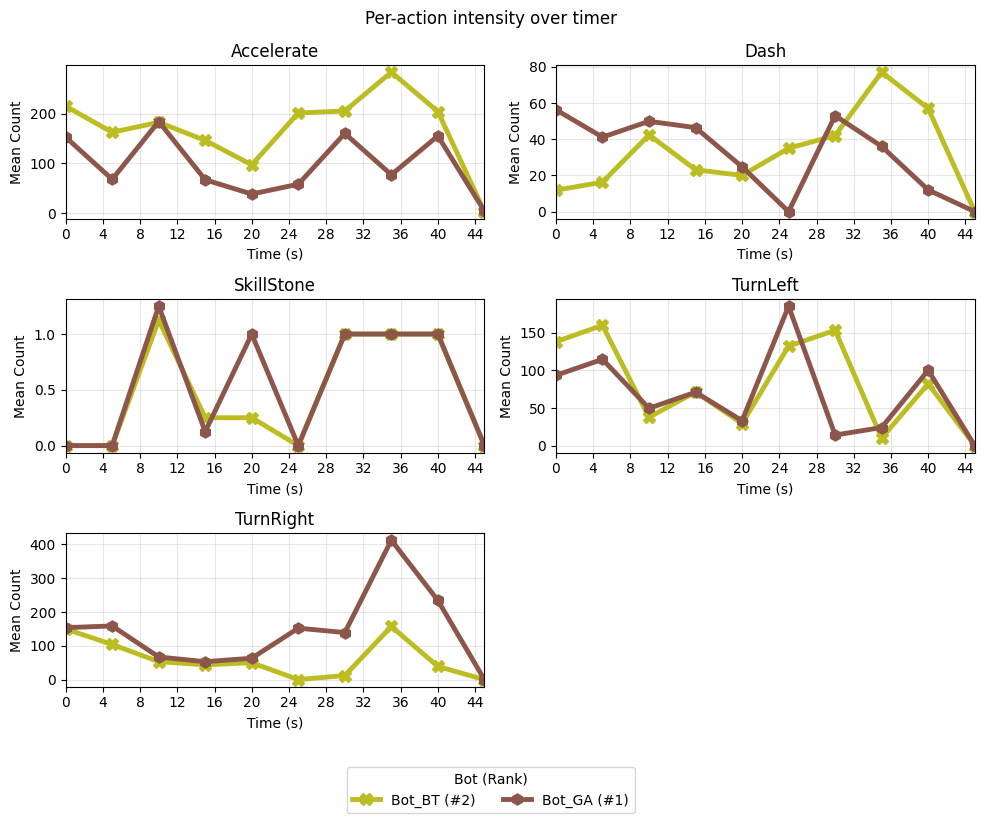

In [36]:
for timI in cfg["Timer"]:
    for actI in cfg["ActInterval"]:
        # Filter for specific config
        filtered = df_timebins[(df_timebins['Timer'] == timI) & (df_timebins['ActInterval'] == actI)]
        print(f"\n--- Timer={timI}, ActionInterval={actI} ---")
        print(f"Sample: {len(filtered)} timebin records")
        
        # Total action intensity
        fig = plot_action_timebins_intensity(df_timebins, timer=timI, act_interval=actI, mode="total", summary_df=df)
        if fig:
            plt.show()
        
        # Per-action intensity
        fig = plot_action_timebins_intensity(df_timebins, timer=timI, act_interval=actI, mode="per_action", summary_df=df)
        if fig:
            plt.show()

### Action Intensity Over All Configuration

In [37]:
# Sample: action intensity over time (all configurations with Timer=60)
filtered = df_timebins[df_timebins['Timer'] == 60]
print(f"Sample: {len(filtered)} timebin records (Timer=60)")
fig = plot_action_timebins_intensity(df_timebins, mode="total", timer=60, summary_df=df)
if fig:
    plt.show()

Sample: 0 timebin records (Timer=60)
⚠️ No data after filtering.


In [38]:
# Sample: per-action intensity over time (all configurations with Timer=60)
print(f"Sample: {len(filtered)} timebin records (Timer=60)")
fig = plot_action_timebins_intensity(df_timebins, mode="per_action", timer=60, summary_df=df)
if fig:
    plt.show()

Sample: 0 timebin records (Timer=60)
⚠️ No data after filtering.


### Collision Intensity Over Time (Per Configuration)

Shows collision intensity over time for different timer and action interval configurations


--- Timer=15.0, ActionInterval=0.1 ---
Sample: 15 collision timebin records


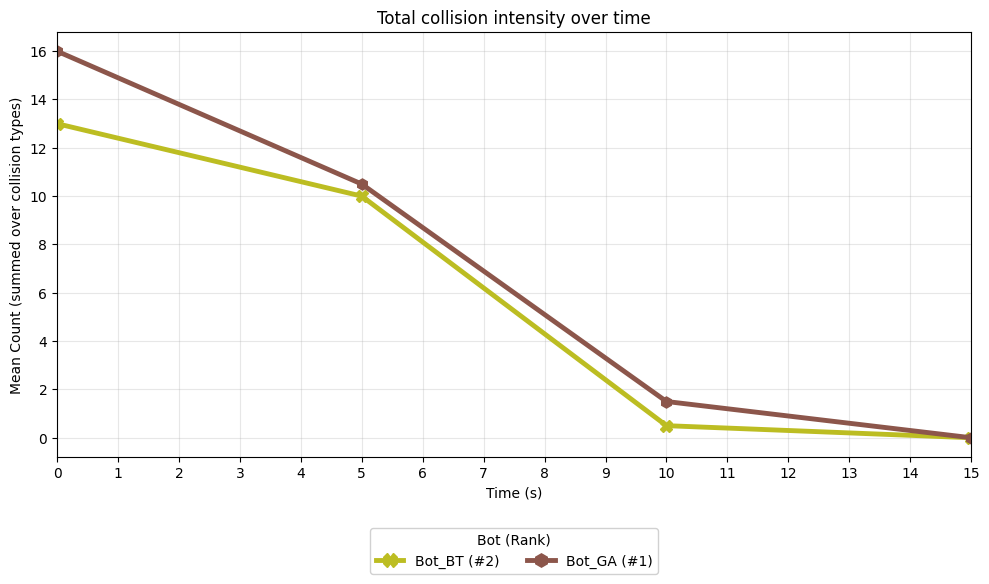

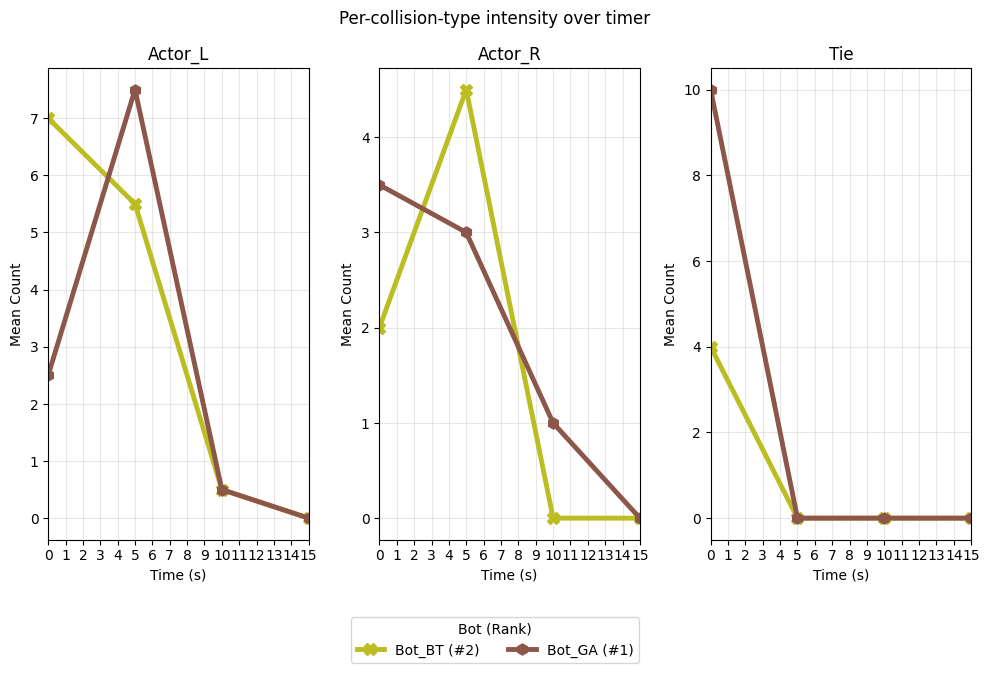


--- Timer=45.0, ActionInterval=0.1 ---
Sample: 24 collision timebin records


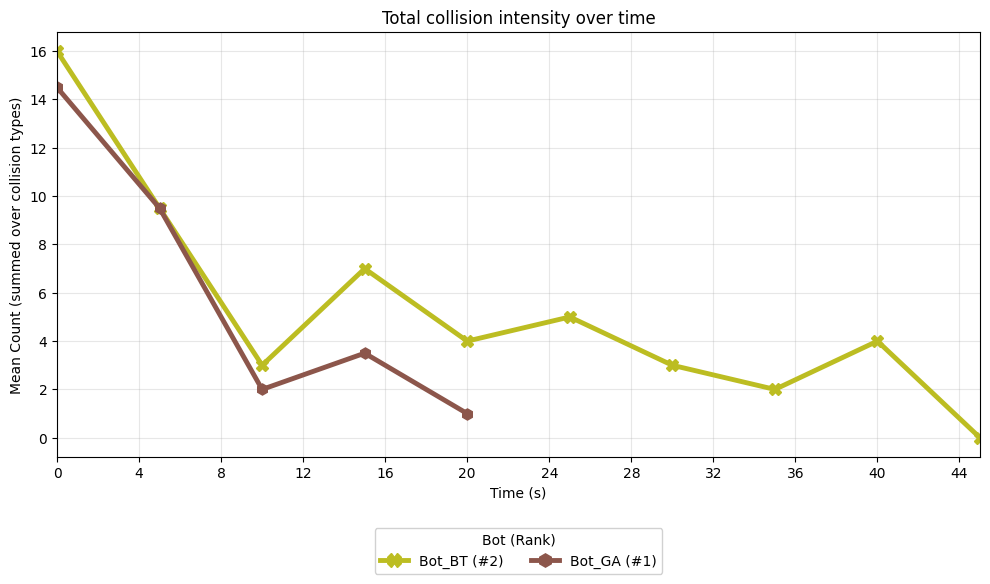

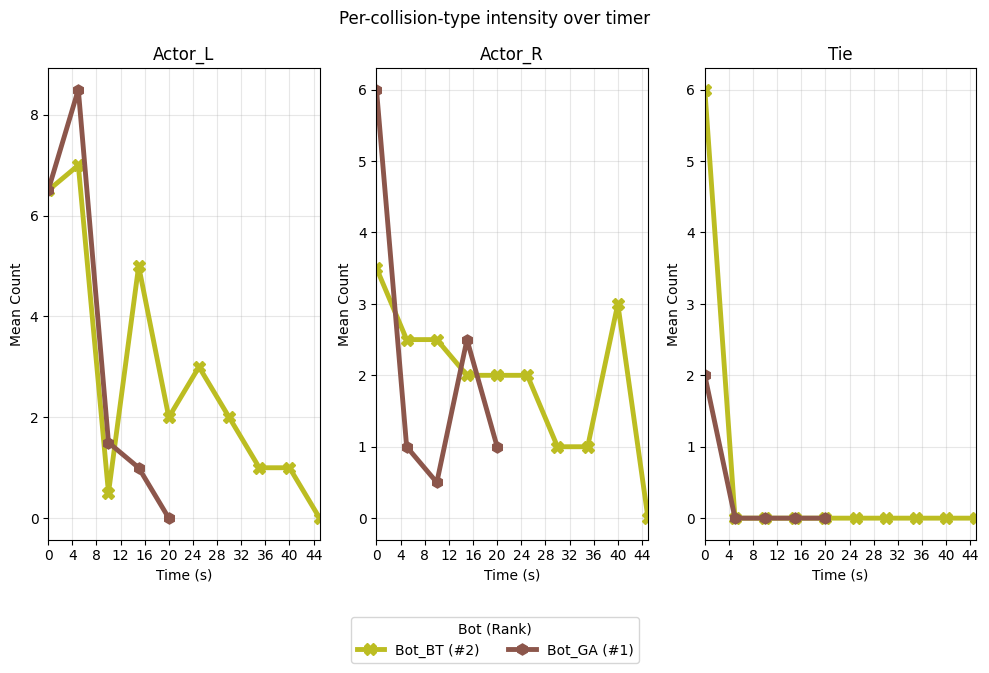

In [39]:
for timI in cfg["Timer"]:
    for actI in cfg["ActInterval"]:
        # Filter for specific config
        filtered = df_collision_timebins[(df_collision_timebins['Timer'] == timI) & (df_collision_timebins['ActInterval'] == actI)]
        print(f"\n--- Timer={timI}, ActionInterval={actI} ---")
        print(f"Sample: {len(filtered)} collision timebin records")
        
        # Total collision intensity
        fig = plot_collision_timebins_intensity(df_collision_timebins, timer=timI, act_interval=actI, mode="total", summary_df=df)
        if fig:
            plt.show()
        
        # Per-type collision intensity
        fig = plot_collision_timebins_intensity(df_collision_timebins, timer=timI, act_interval=actI, mode="per_type", summary_df=df)
        if fig:
            plt.show()

### Collision Detail Distribution per Bots

Sample: 8 config-matchup pairs → 2 bots


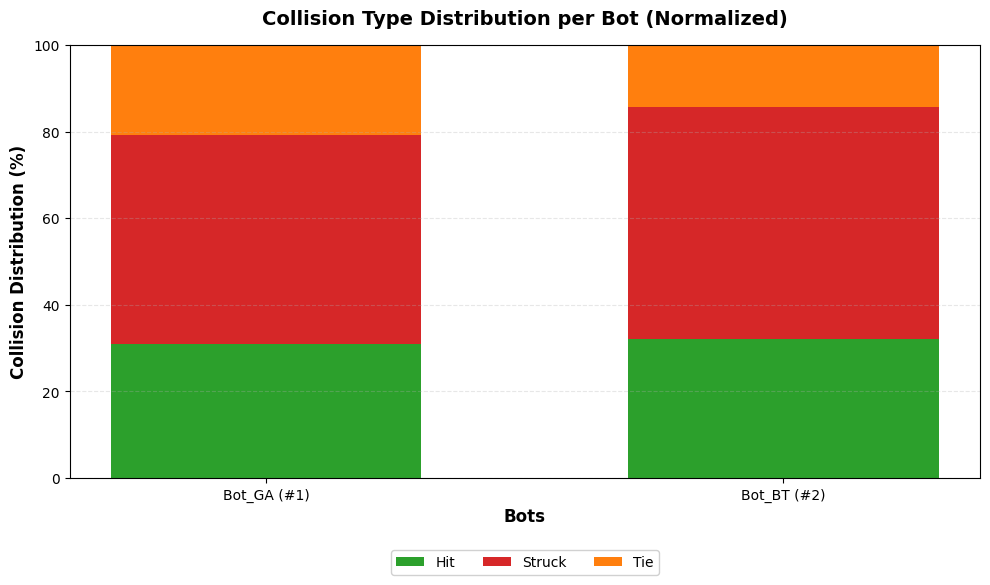

In [40]:
# Sample: collision type distribution per bot (all configurations aggregated)
print(f"Sample: {len(df)} config-matchup pairs → {len(df['Bot_L'].unique())} bots")
fig = plot_collision_distribution_stacked(df, normalize=True)
plt.show()

### Collision Intensity Over All Configuration

Sample: 24 collision timebin records 45.0s


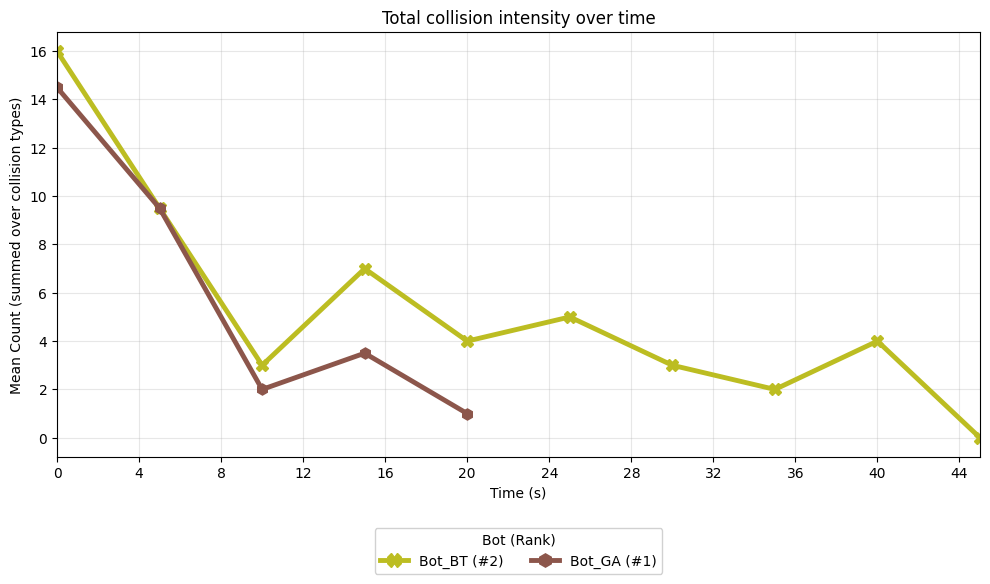

In [49]:
# Sample: collision intensity over time (all configurations)
filtered = df_collision_timebins[df_collision_timebins['Timer'] == max(cfg["Timer"])]
print(f"Sample: {len(filtered)} collision timebin records {max(cfg['Timer'])}s")
fig = plot_collision_timebins_intensity(df_collision_timebins, mode="total", timer=max(cfg["Timer"]), summary_df=df)
if fig:
    plt.show()

Sample: 24 collision timebin records (Timer=45.0)


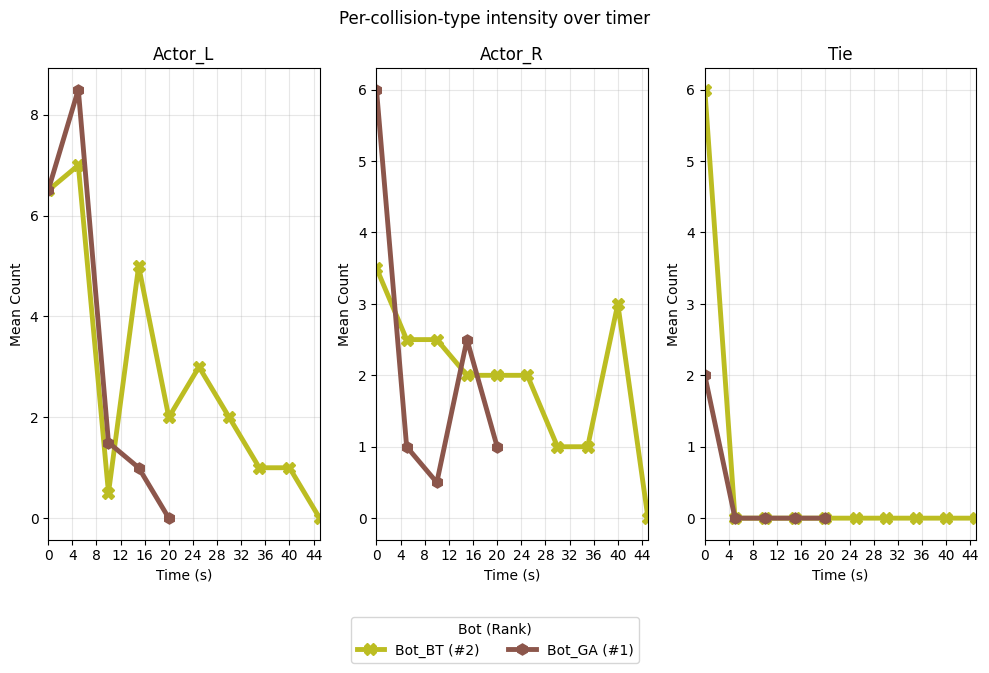

In [50]:
# Sample: per-type collision intensity over time (all configurations)
print(f"Sample: {len(filtered)} collision timebin records (Timer={max(cfg['Timer'])})")
fig = plot_collision_timebins_intensity(df_collision_timebins, mode="per_type", timer=max(cfg["Timer"]), summary_df=df)
if fig:
    plt.show()

### Action Taken vs. Win Relation

Does spending most action (aggressive) lead to a win?
This taking mean of action-taken per games versus win-rate

2026-01-03 09:34:42.934 No runtime found, using MemoryCacheStorageManager
2026-01-03 09:34:42.938 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:42.939 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:42.940 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:42.940 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:42.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:42.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-03 09:34:42.975 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Sample: 8 config-matchup pairs (both Bot_L and Bot_R sides)
Correlation between Actions and Win Rate: -0.070


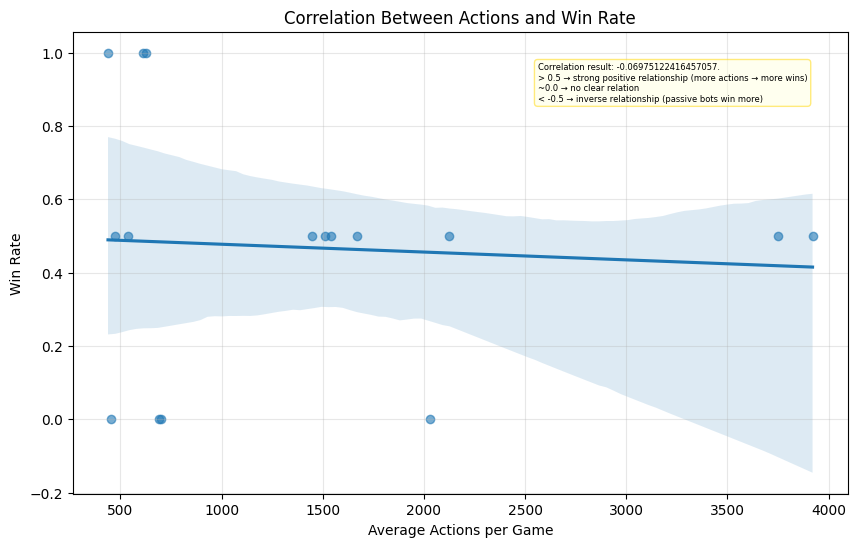

In [43]:
# Sample: average actions per game vs winrate (all bots, all configs)
print(f"Sample: {len(df)} config-matchup pairs (both Bot_L and Bot_R sides)")
fig = plot_action_win_related(df, width, height)
plt.show()

### Pearson Correlation Analysis (Overall)

Correlation analysis using Pearson coefficient with scatter plots and regression lines.
All data from all bots combined, separated by configuration

Sample: 8 config-matchup pairs × 2 perspectives = 16 data points


/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/overall_analyzer.py:1621: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, pearson_p = stats.pearsonr(plot_data[x_col], plot_data[y_col])
/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/overall_analyzer.py:1676: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x_values, plot_data[y_col], 1)
/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/overall_analyzer.py:1621: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, pearson_p = stats.pearsonr(plot_data[x_col], plot_data[y_col])
/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/overall_analyzer.py:1676: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x_values, plot_data[y_col], 1)
/Users/defdef/Development/research/sumobot/sumobot-analytic/

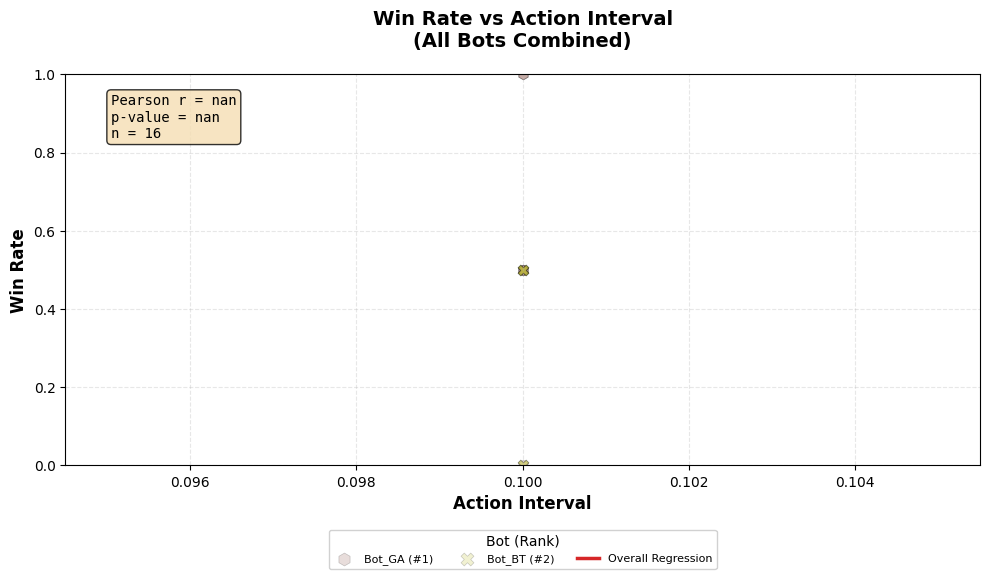

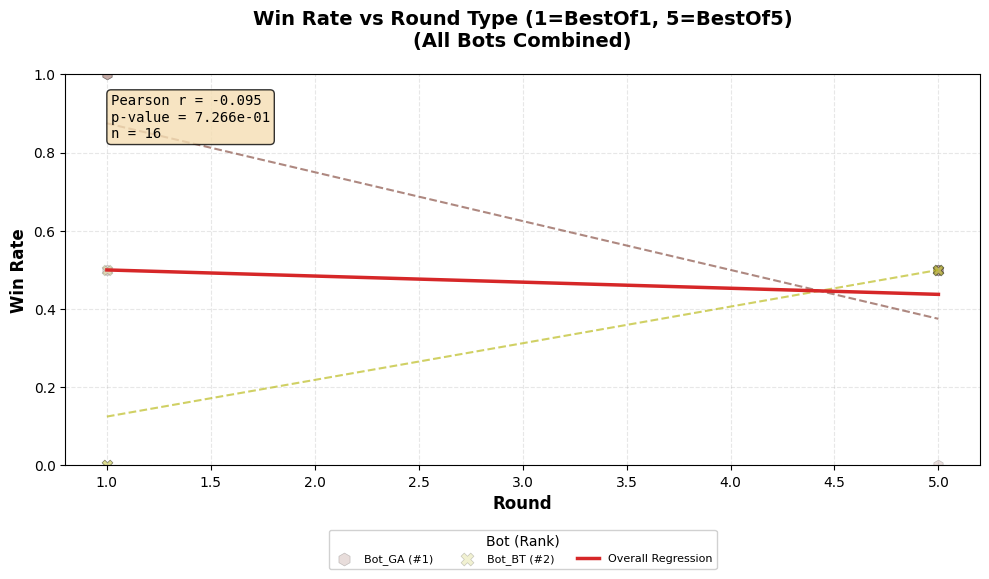

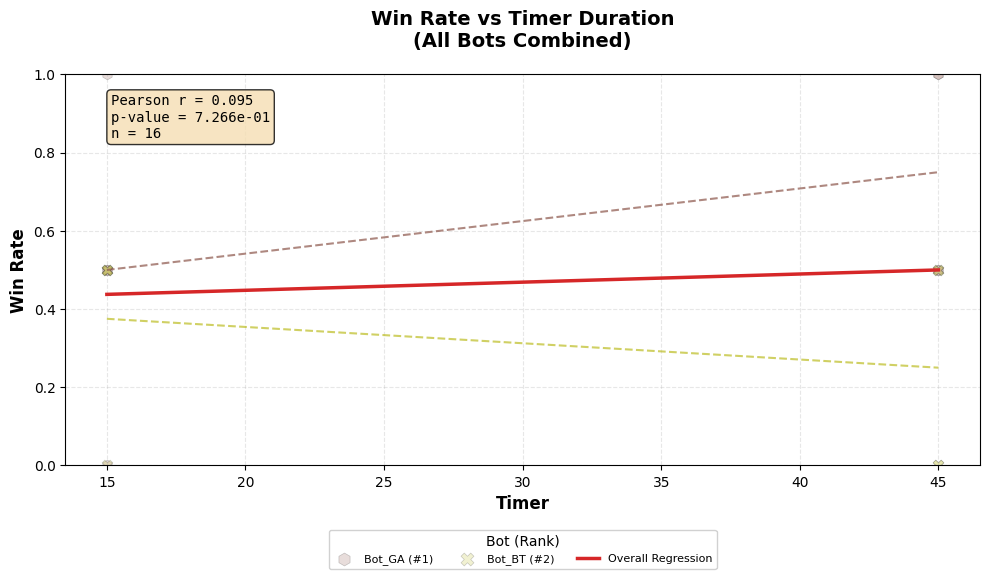

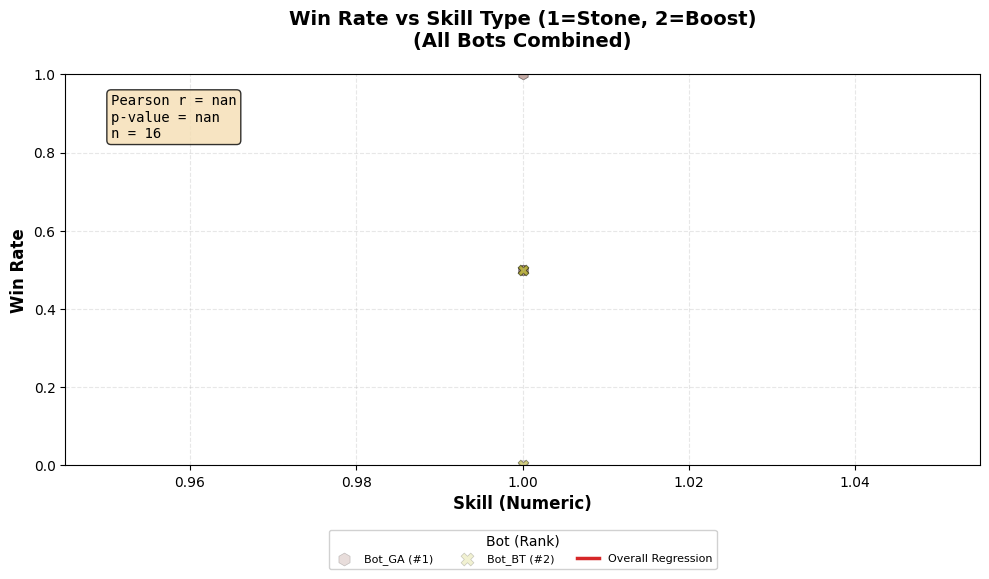

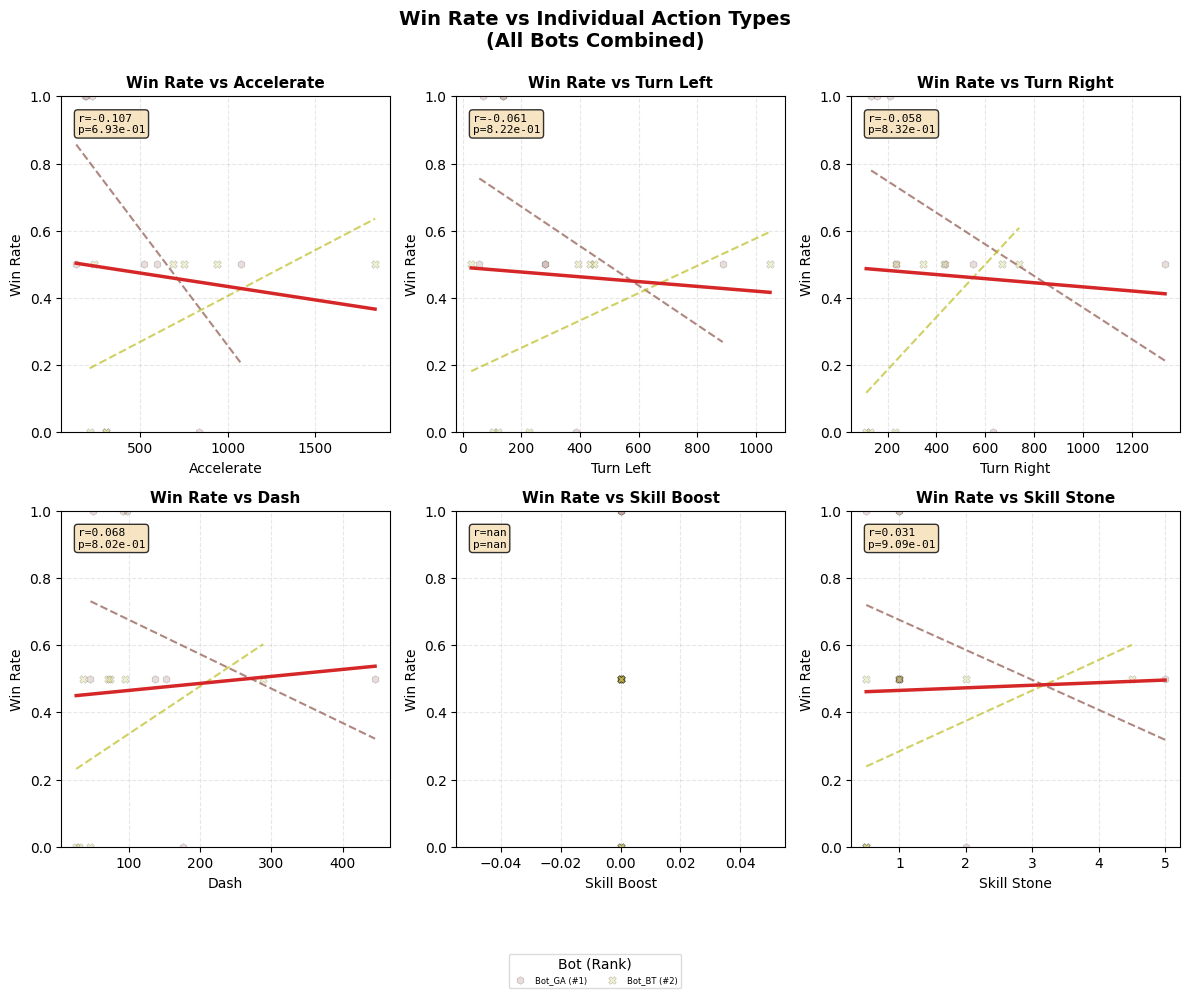

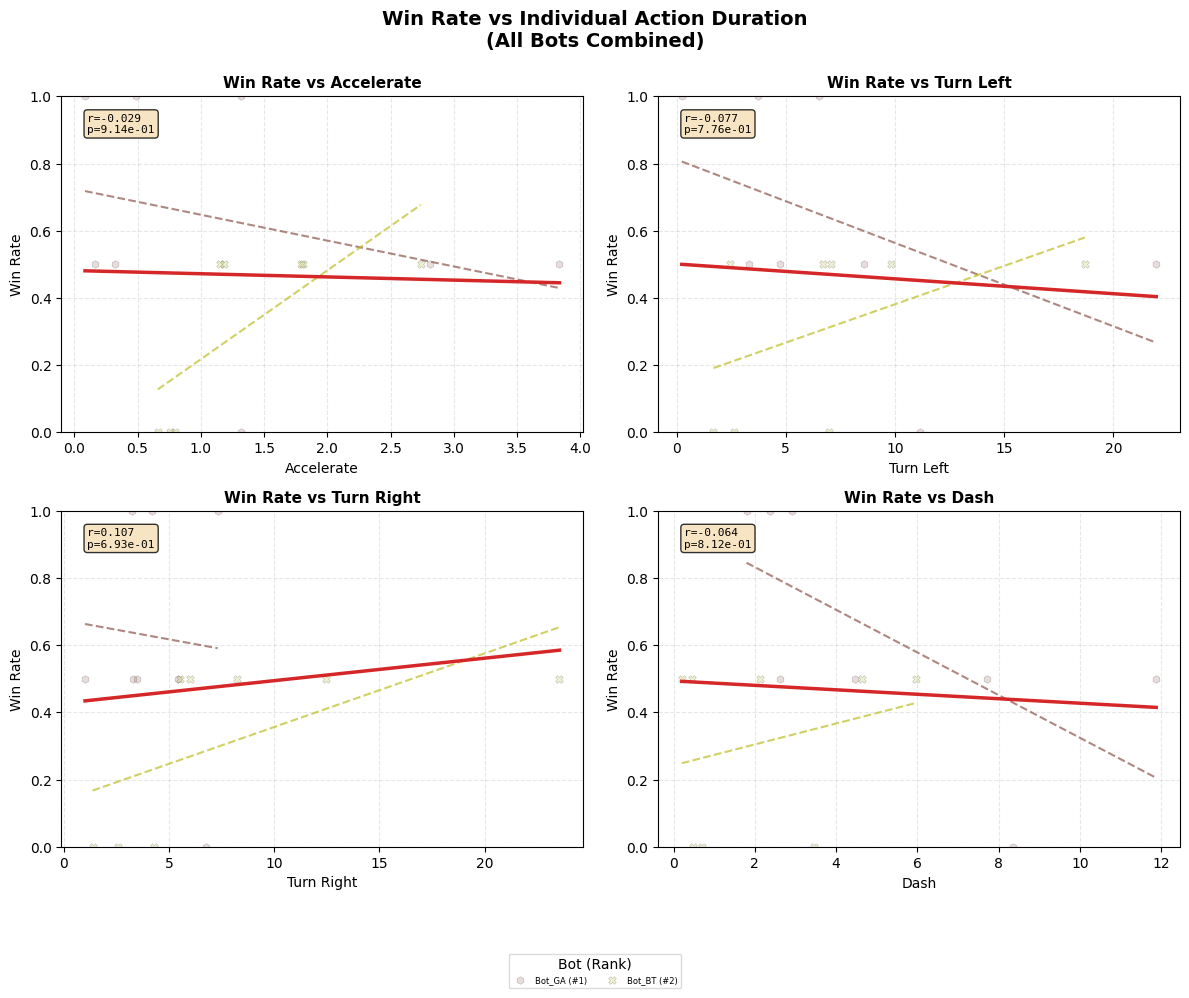

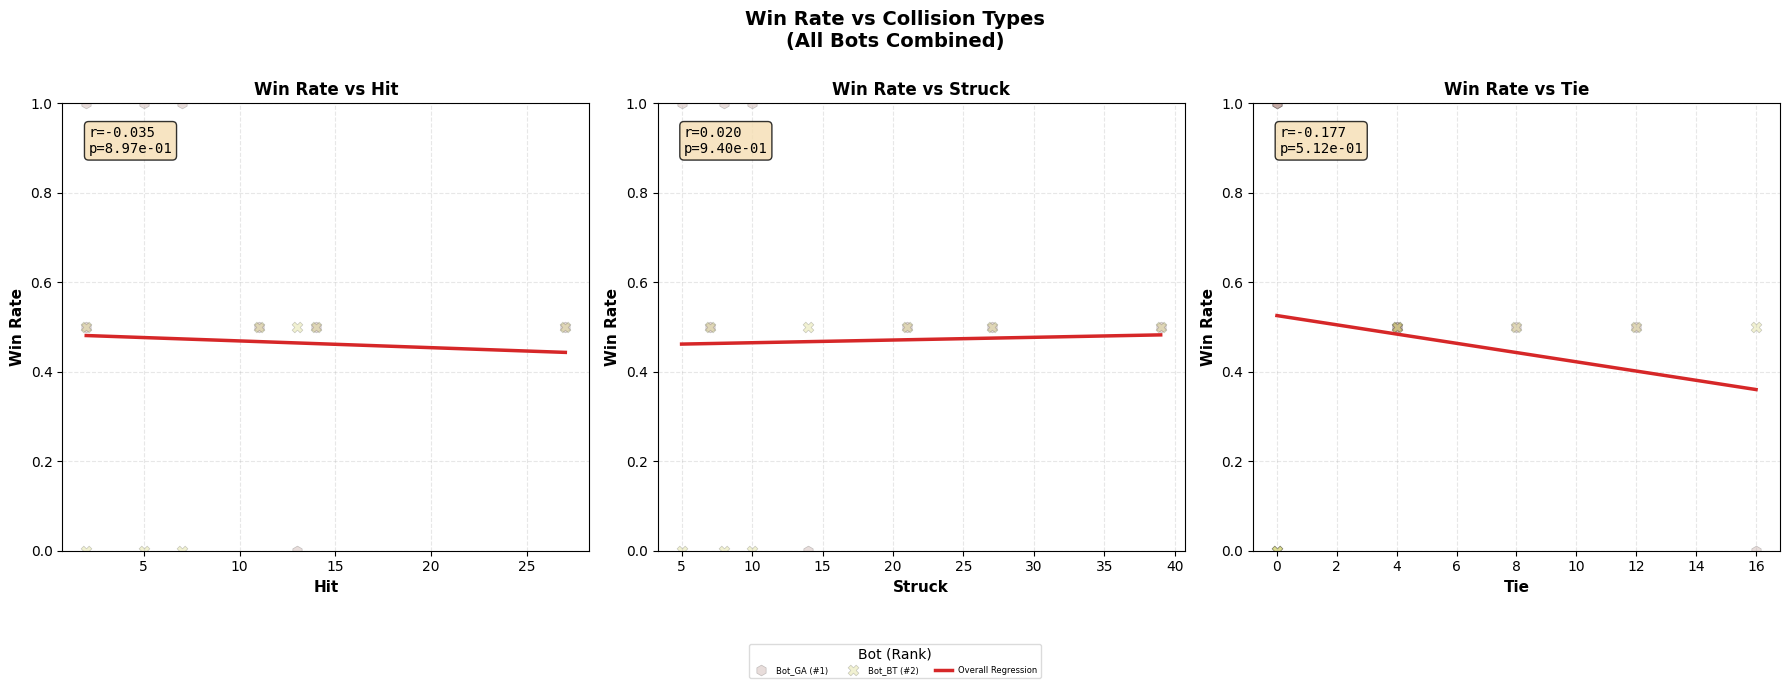

In [44]:
# Sample: correlation analysis combines both Bot_L and Bot_R perspectives
correlation_data_size = len(df) * 2  # Each config-matchup has 2 bot perspectives
print(f"Sample: {len(df)} config-matchup pairs × 2 perspectives = {correlation_data_size} data points")
correlation_figs = plot_all_correlations(df, width, height)

## Individual Bot Analysis

Analyze bot agent against its different configurations.
Each of report: Win Rate; Collision; Action-Taken; Duration; is calculated with averaging data from matchup (left and right position)

### Pearson Correlation Analysis (Per Bot)

Detailed plots for individual bots, separated by configuration

Analyzing 2 bots: ['Bot_BT', 'Bot_GA']

Analyzing correlations for Bot_BT
Sample: 4 as Bot_L + 4 as Bot_R = 8 data points


/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/individual_analyzer.py:303: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, pearson_p = stats.pearsonr(plot_data[x_col], plot_data[y_col])
/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/individual_analyzer.py:317: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x_values, plot_data[y_col], 1)
/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/individual_analyzer.py:303: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, pearson_p = stats.pearsonr(plot_data[x_col], plot_data[y_col])
/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/individual_analyzer.py:317: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x_values, plot_data[y_col], 1)
/Users/defdef/Development/research/sumobot/sumobot-a


--- Win Rate vs Action Interval Configuration ---


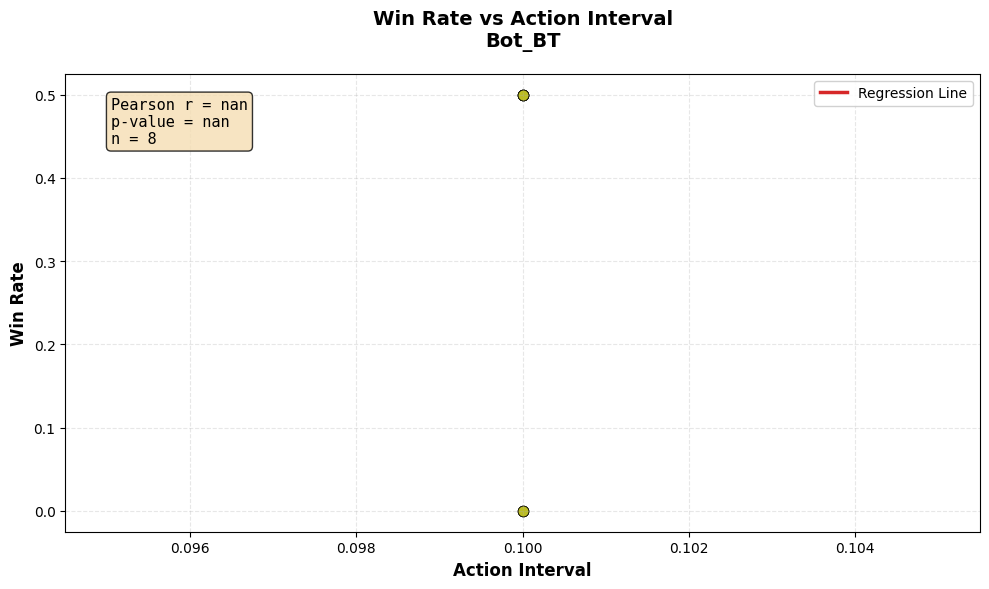

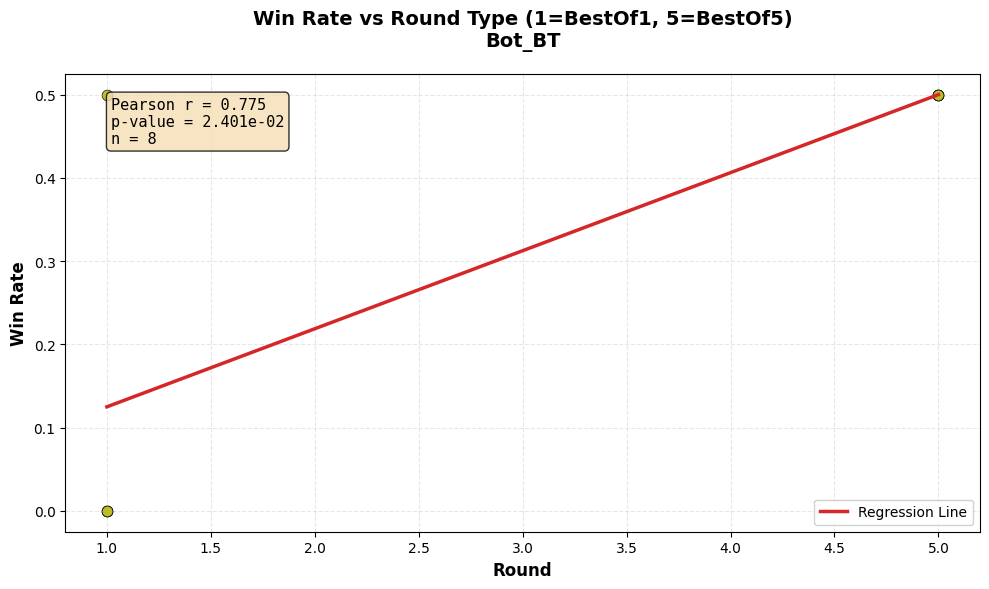

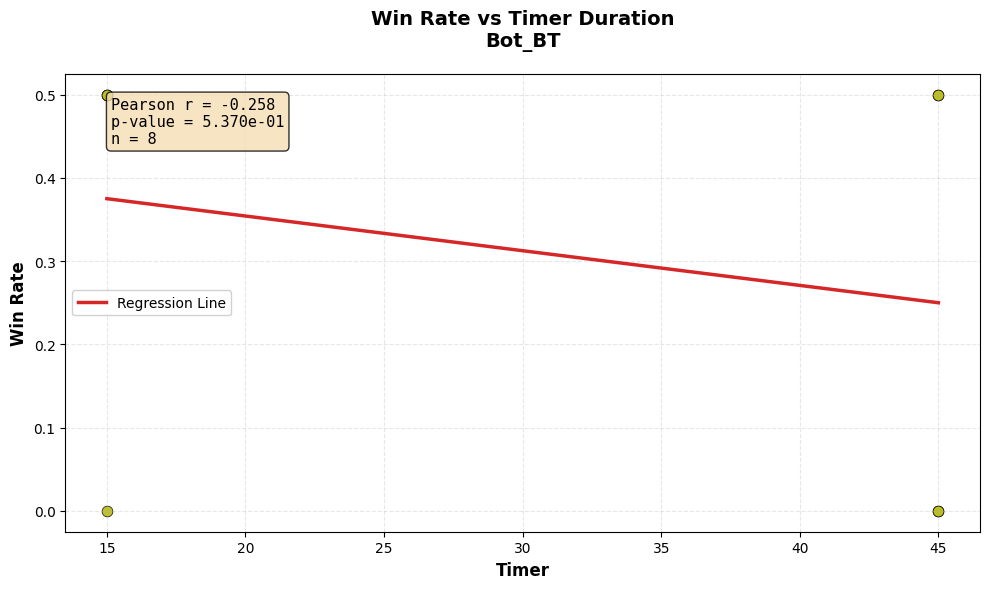

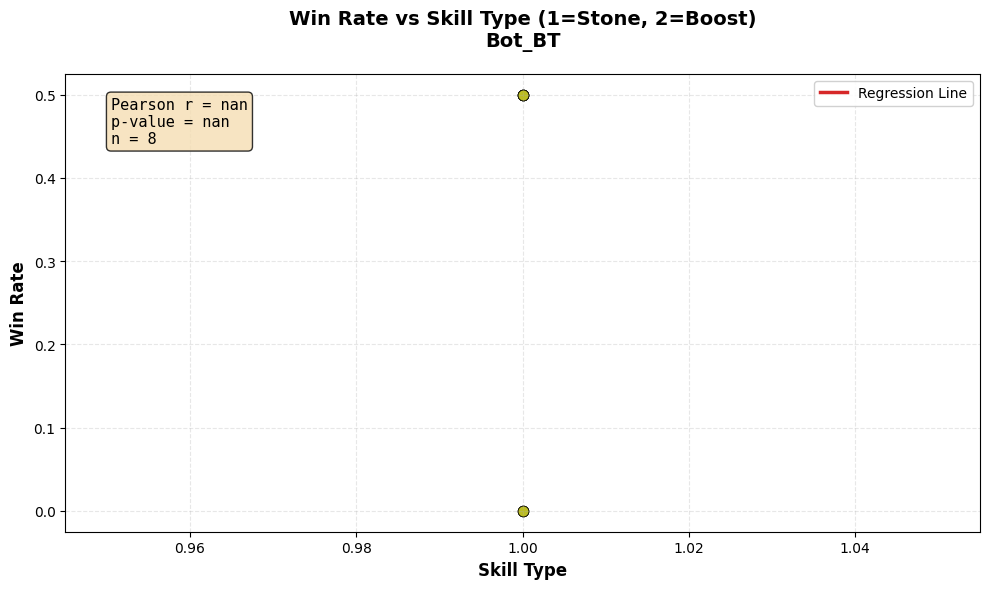

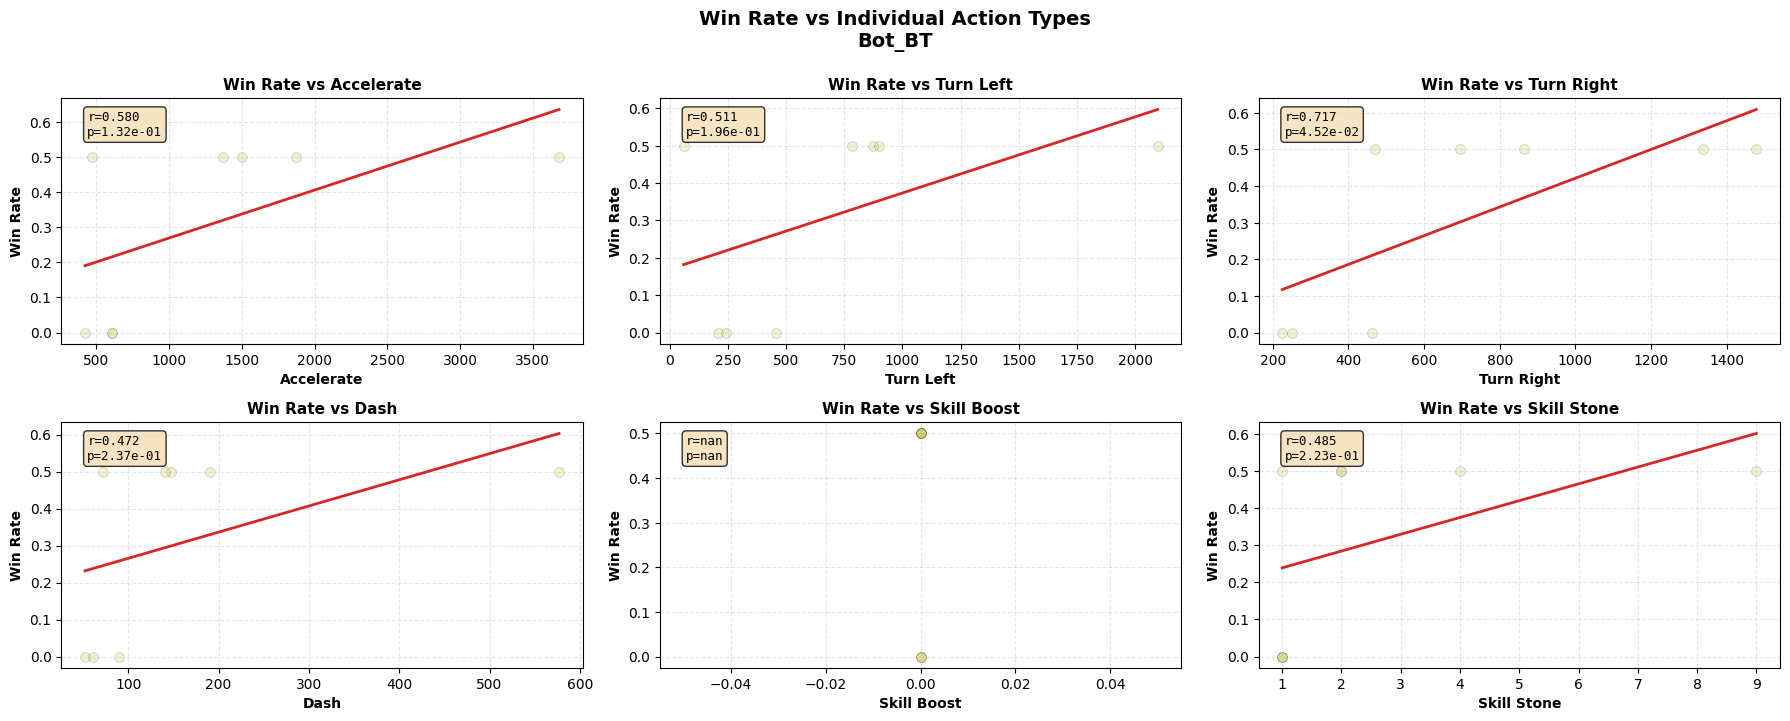

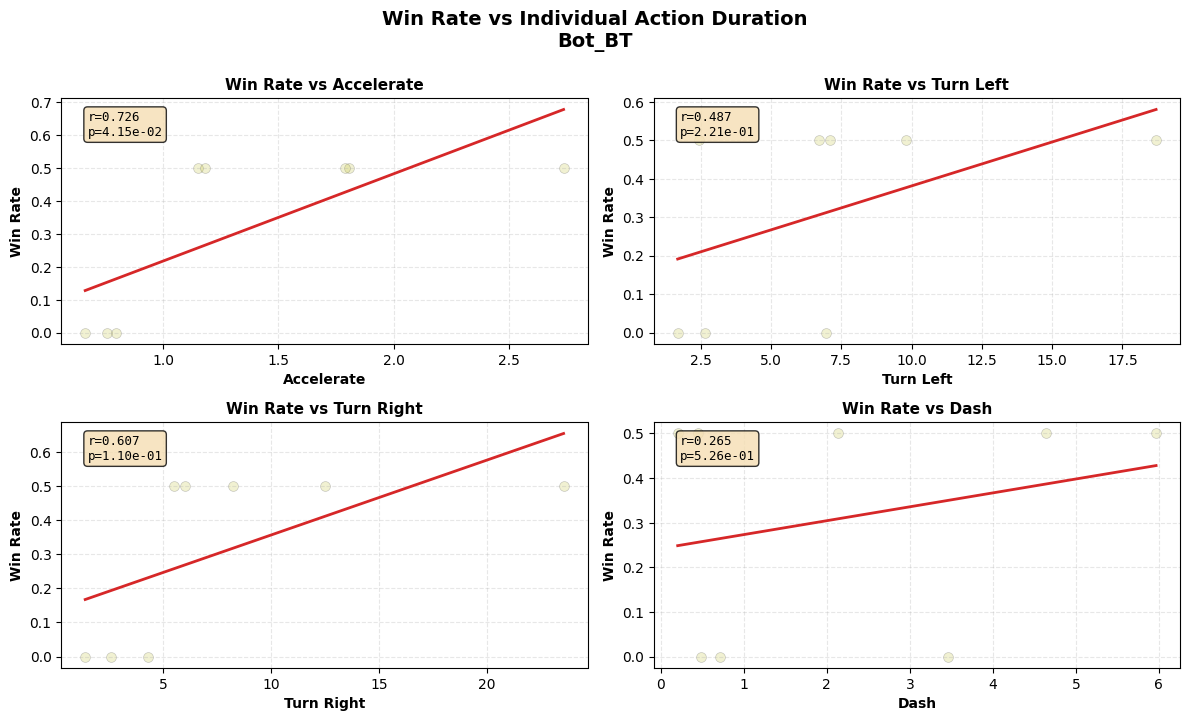

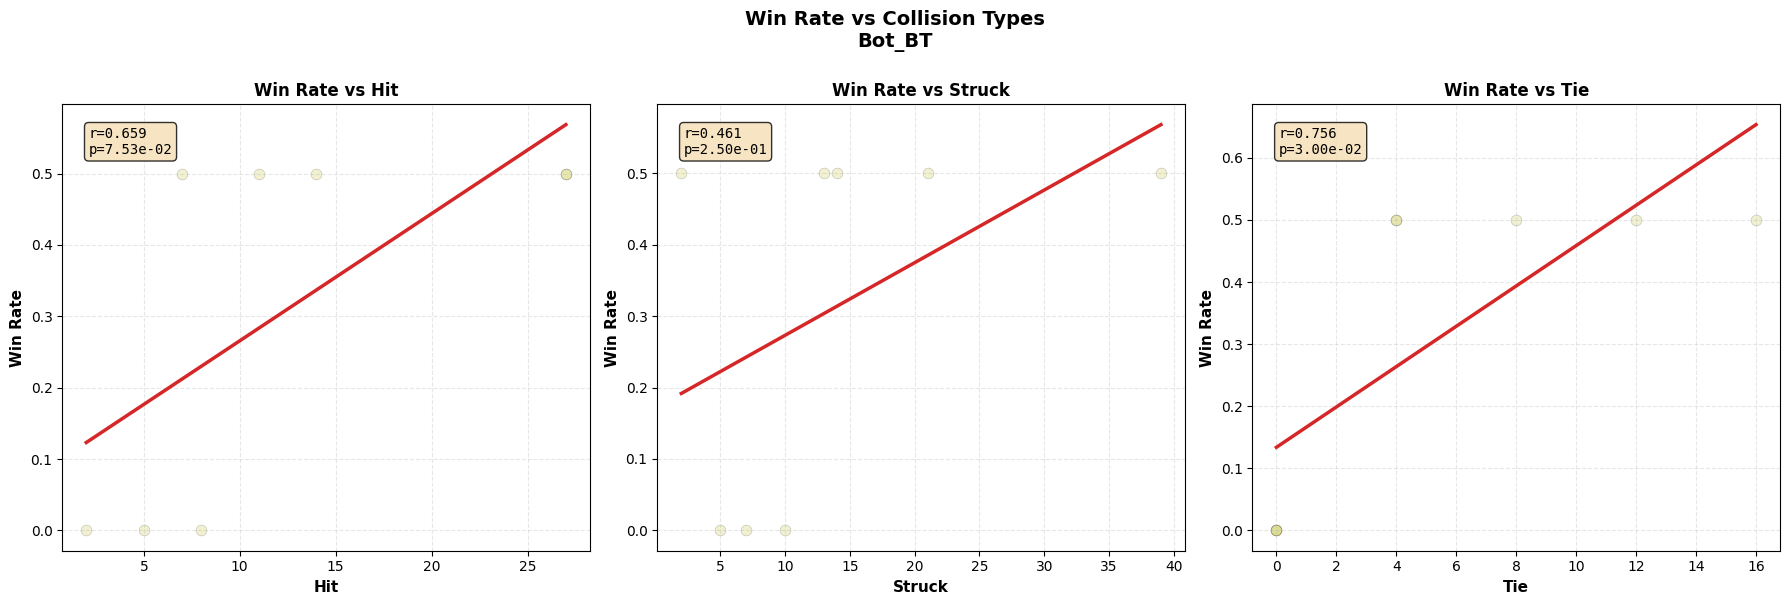


--- Win Rate vs Round Type Configuration ---

--- Win Rate vs Timer Configuration ---

--- Win Rate vs Skill Type Configuration ---

--- Win Rate vs Individual Action Types ---

--- Win Rate vs Individual Action Duration ---

--- Win Rate vs Collision Types (Hit, Struck, Tie) ---

Analyzing correlations for Bot_GA
Sample: 4 as Bot_L + 4 as Bot_R = 8 data points


/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/individual_analyzer.py:303: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, pearson_p = stats.pearsonr(plot_data[x_col], plot_data[y_col])
/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/individual_analyzer.py:317: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x_values, plot_data[y_col], 1)
/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/individual_analyzer.py:303: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_r, pearson_p = stats.pearsonr(plot_data[x_col], plot_data[y_col])
/Users/defdef/Development/research/sumobot/sumobot-analytic/plotting/individual_analyzer.py:317: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(x_values, plot_data[y_col], 1)
/Users/defdef/Development/research/sumobot/sumobot-a


--- Win Rate vs Action Interval Configuration ---


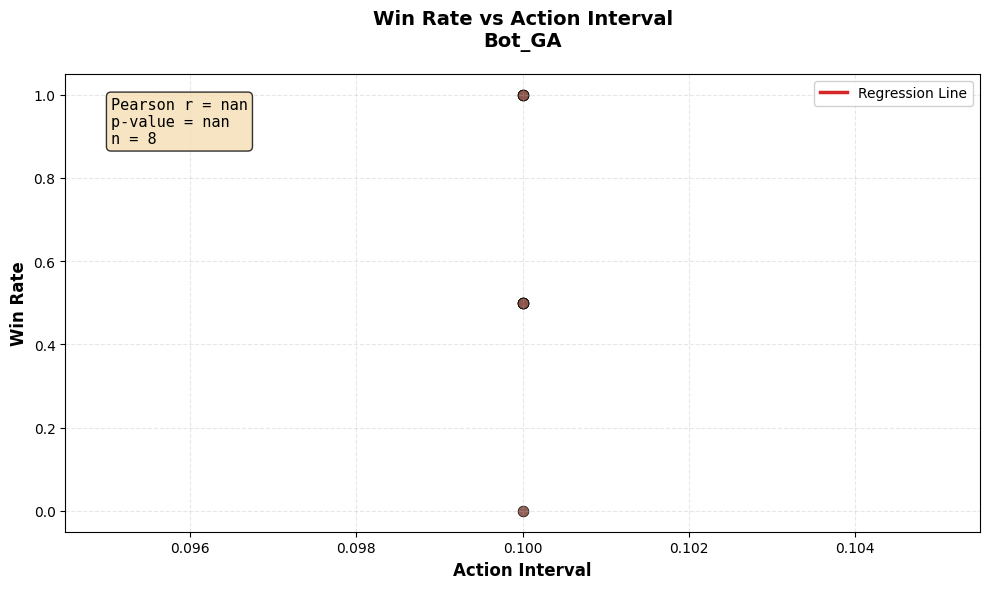

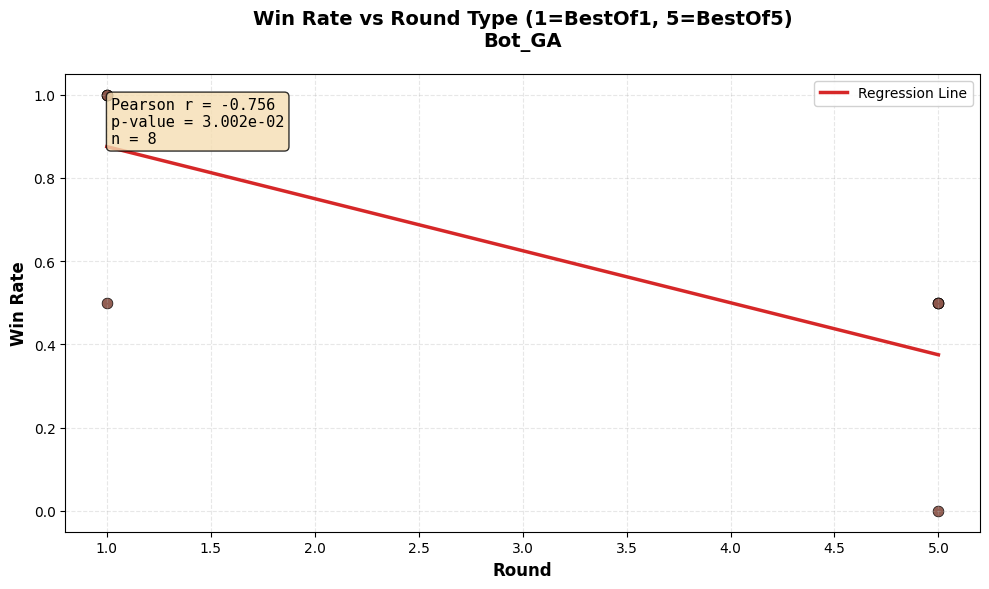

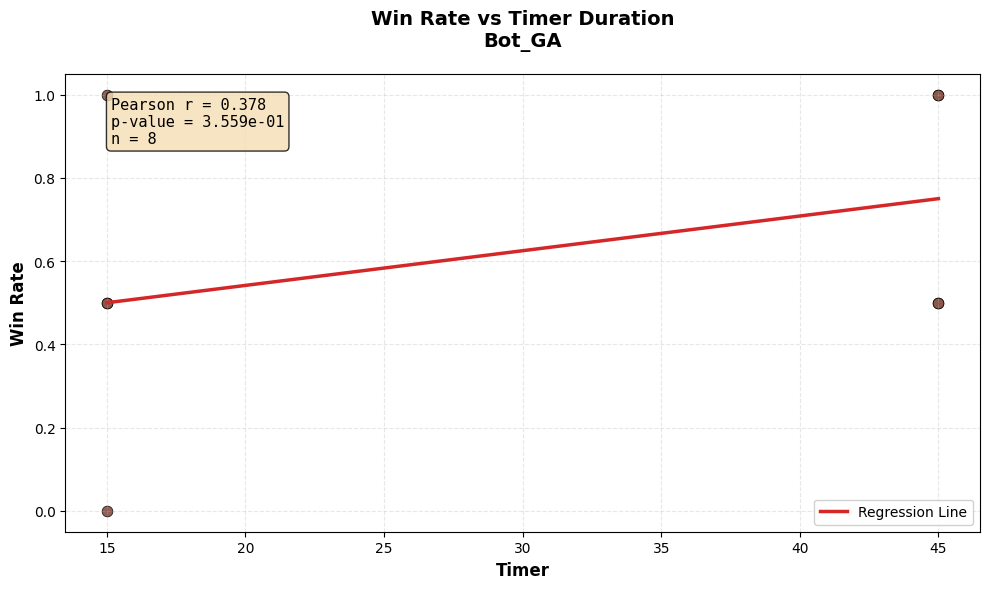

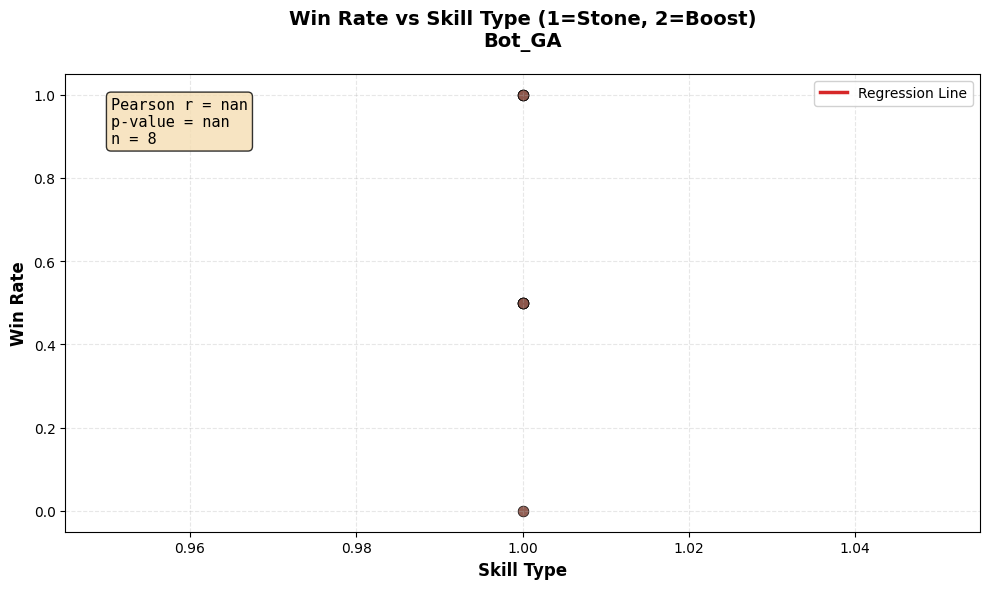

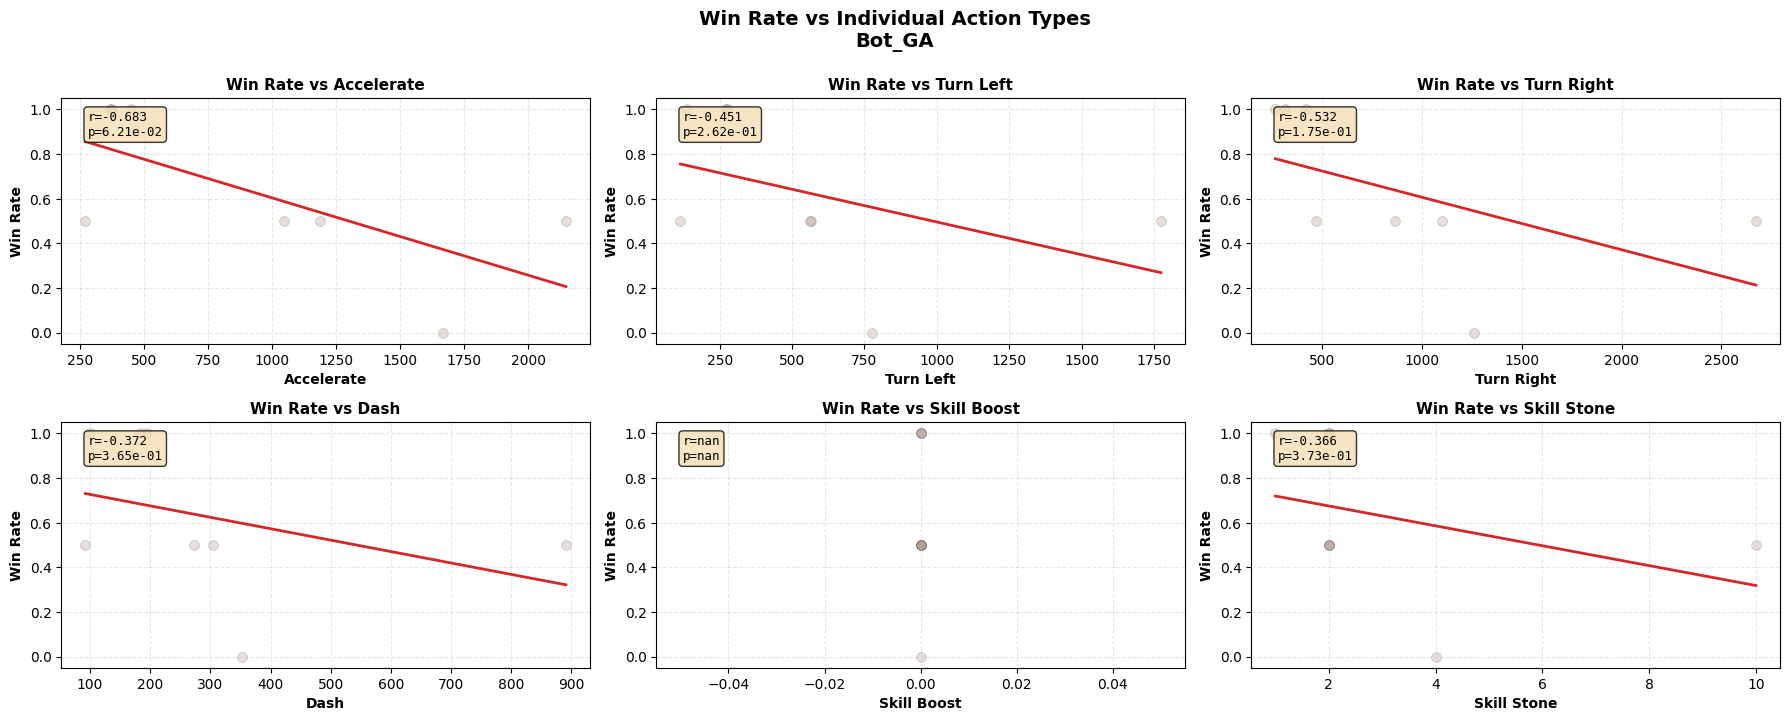

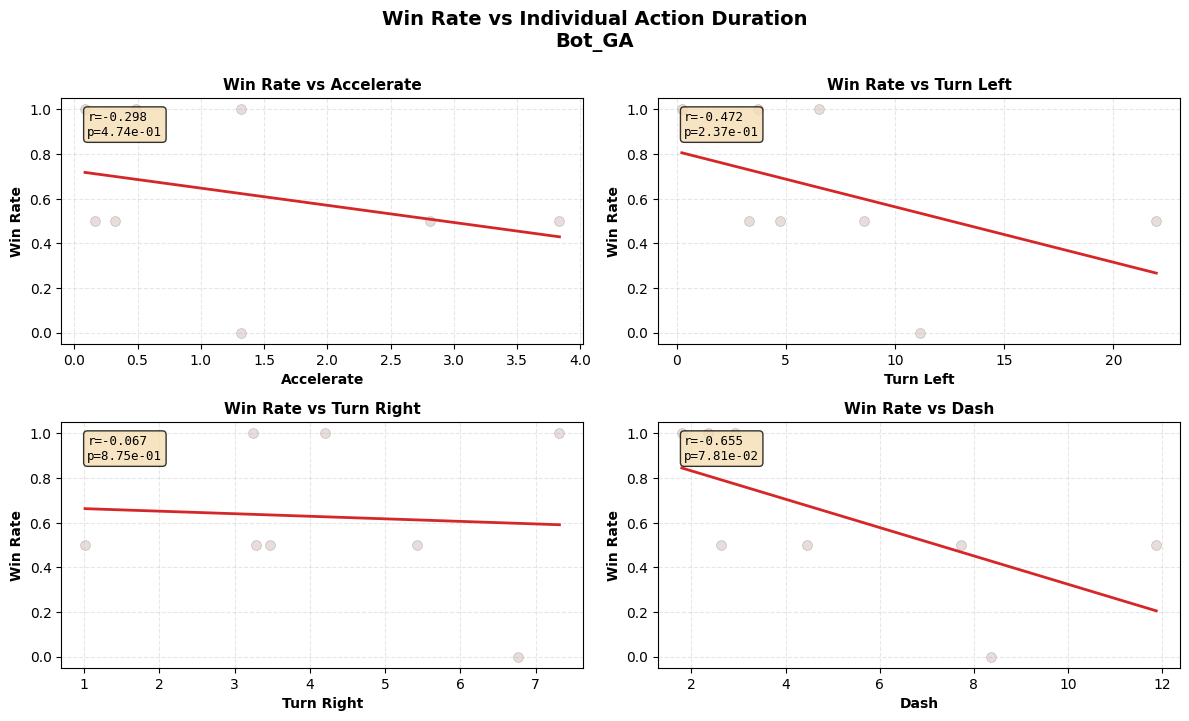

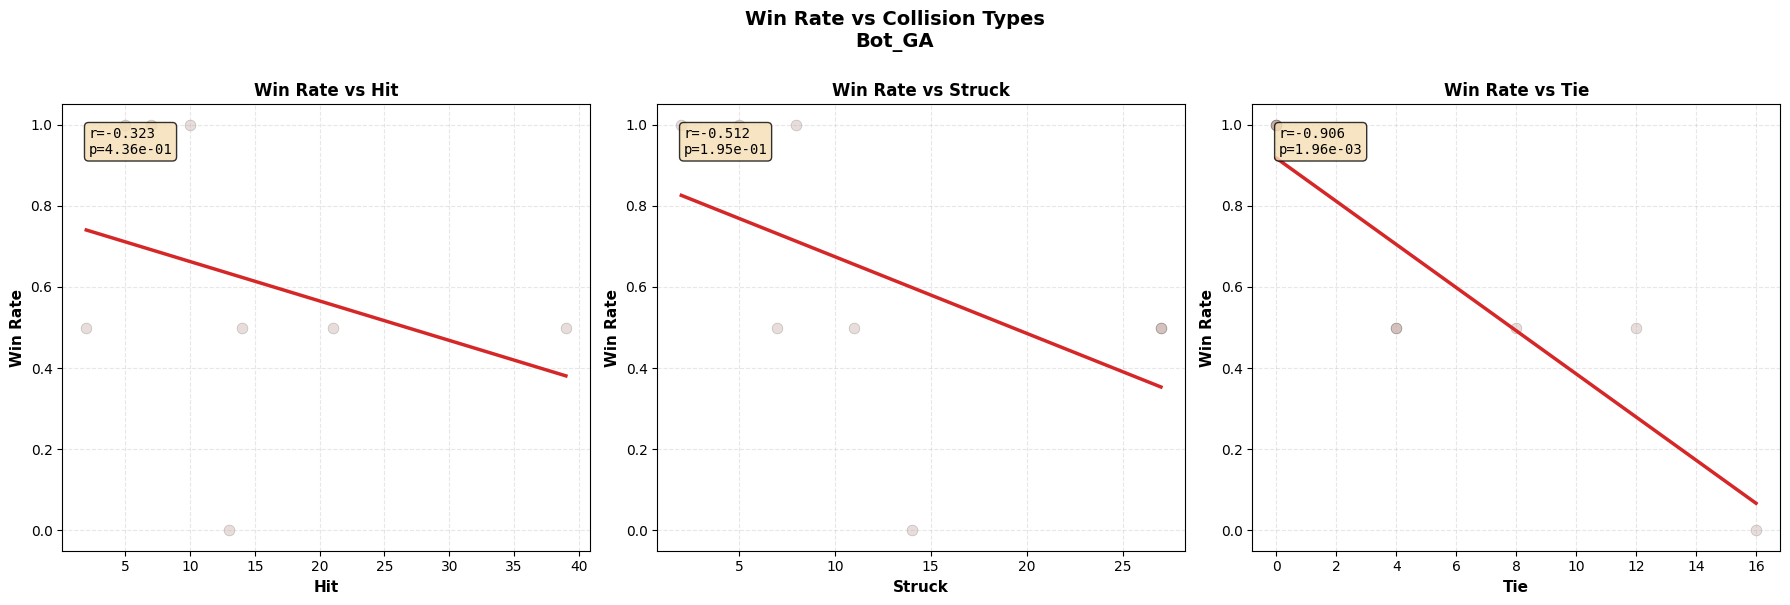


--- Win Rate vs Round Type Configuration ---

--- Win Rate vs Timer Configuration ---

--- Win Rate vs Skill Type Configuration ---

--- Win Rate vs Individual Action Types ---

--- Win Rate vs Individual Action Duration ---

--- Win Rate vs Collision Types (Hit, Struck, Tie) ---


In [45]:
# Get unique bots
bots_list = sorted(df['Bot_L'].unique())
print(f"Analyzing {len(bots_list)} bots: {bots_list}")

# Individual bot correlation analysis
for bot in bots_list:
    print(f"\n{'='*60}")
    print(f"Analyzing correlations for {bot}")
    
    # Calculate sample size for this bot
    bot_left = len(df[df['Bot_L'] == bot])
    bot_right = len(df[df['Bot_R'] == bot])
    bot_total = bot_left + bot_right
    print(f"Sample: {bot_left} as Bot_L + {bot_right} as Bot_R = {bot_total} data points")
    print(f"{'='*60}")
    
    correlation_figs = plot_individual_bot_correlations(df, bot, width, height)
    
    if not correlation_figs:
        print(f"No data available for {bot}")
        continue
    
    # Win Rate vs ActInterval
    if 'actinterval' in correlation_figs:
        print("\n--- Win Rate vs Action Interval Configuration ---")
        plt.show()
    
    # Win Rate vs Round Type
    if 'roundtype' in correlation_figs:
        print("\n--- Win Rate vs Round Type Configuration ---")
        plt.show()
    
    # Win Rate vs Timer
    if 'timer' in correlation_figs:
        print("\n--- Win Rate vs Timer Configuration ---")
        plt.show()
    
    # Win Rate vs Skill Type
    if 'skilltype' in correlation_figs:
        print("\n--- Win Rate vs Skill Type Configuration ---")
        plt.show()
    
    # Win Rate vs Action Types
    if 'actions' in correlation_figs:
        print("\n--- Win Rate vs Individual Action Types ---")
        plt.show()
    
    # Win Rate vs Action Duration
    if 'actions_dur' in correlation_figs:
        print("\n--- Win Rate vs Individual Action Duration ---")
        plt.show()
    
    # Win Rate vs Collisions
    if 'collisions' in correlation_figs:
        print("\n--- Win Rate vs Collision Types (Hit, Struck, Tie) ---")
        plt.show()

### Arena Heatmaps - Bot Movement Analysis

Visualize bot movement patterns across different game phases (Early, Mid, Late)


Bot_GA (#1)


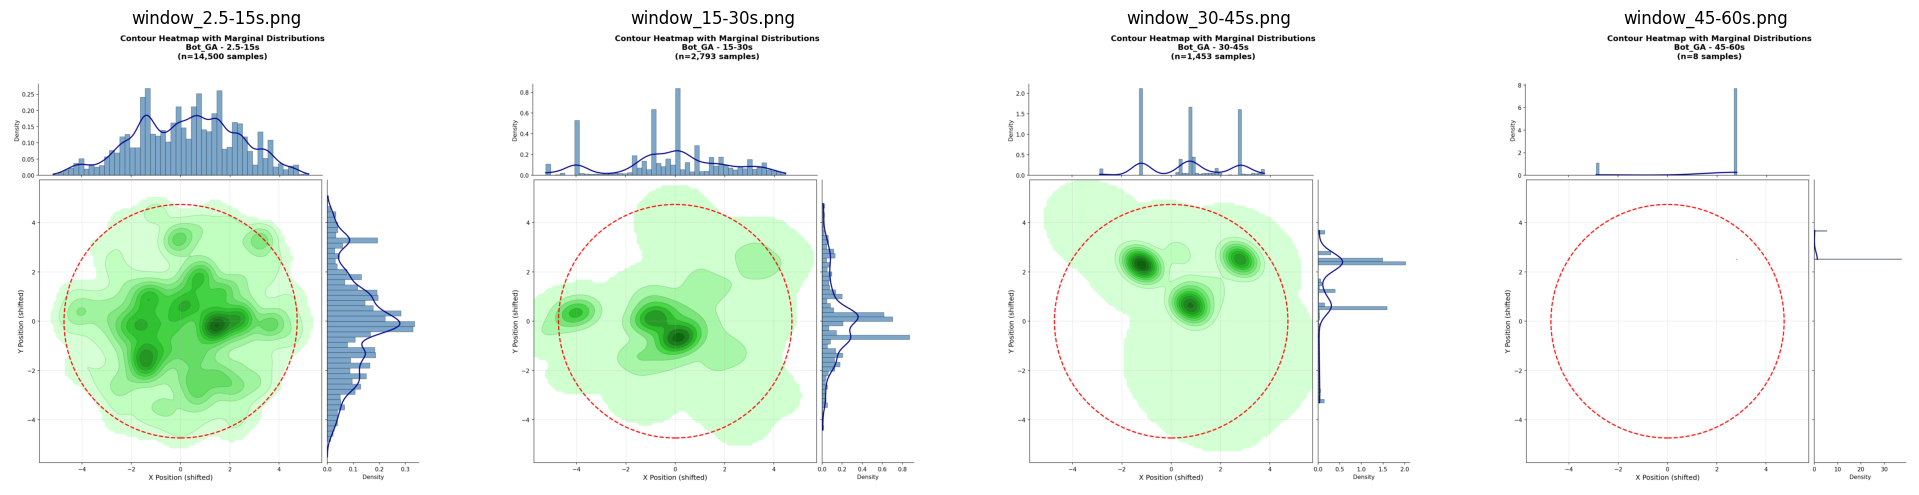


Position Distribution (X & Y Overlayed)


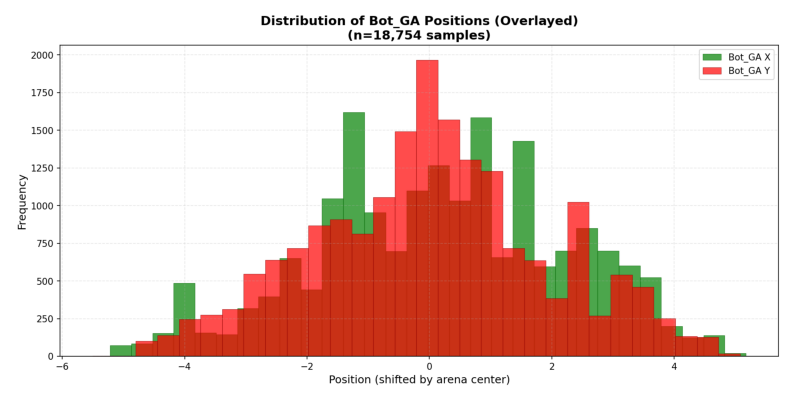


Full Configuration Analysis


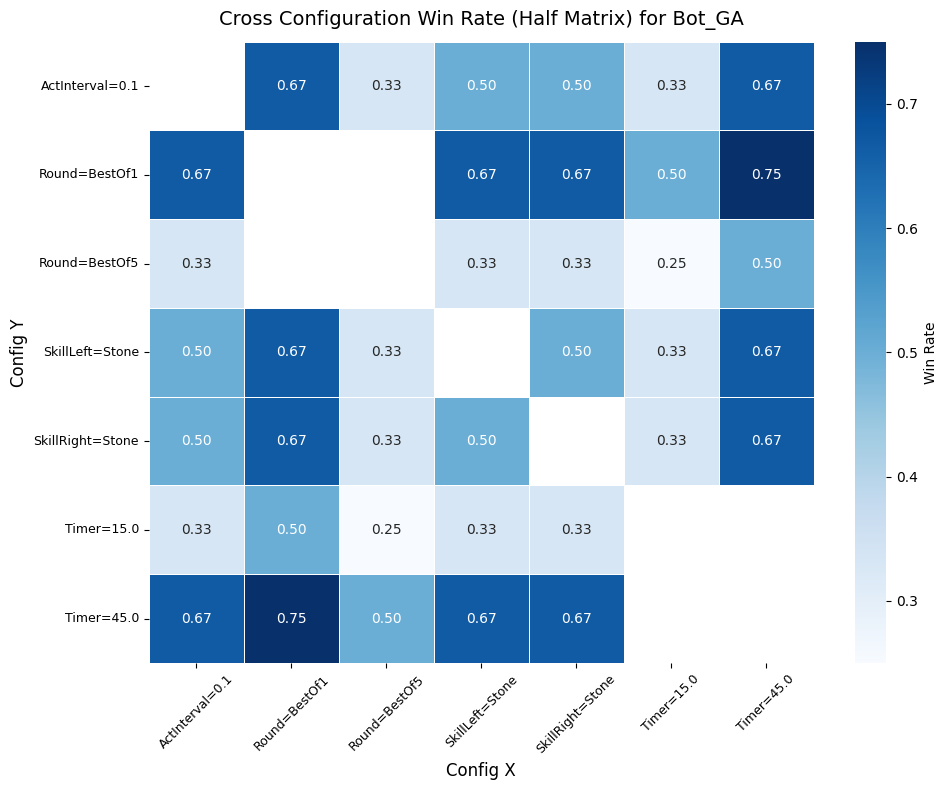


Bot_BT (#2)


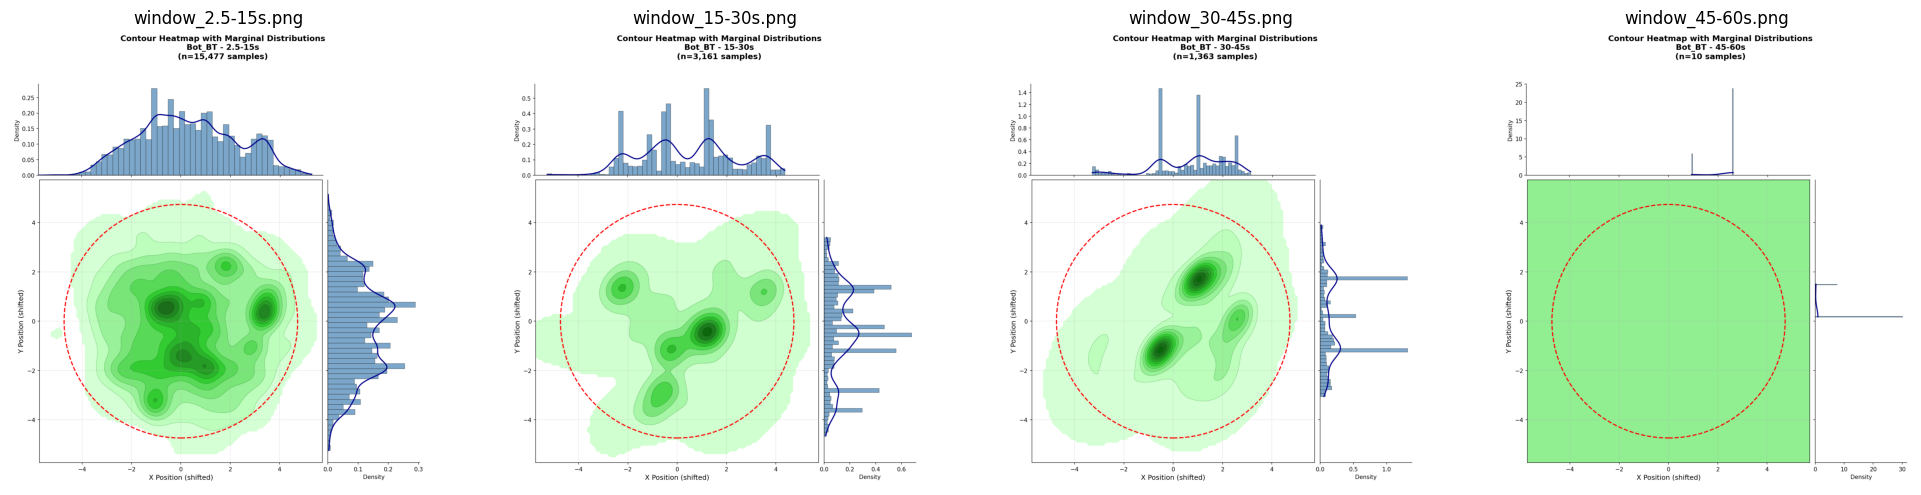


Position Distribution (X & Y Overlayed)


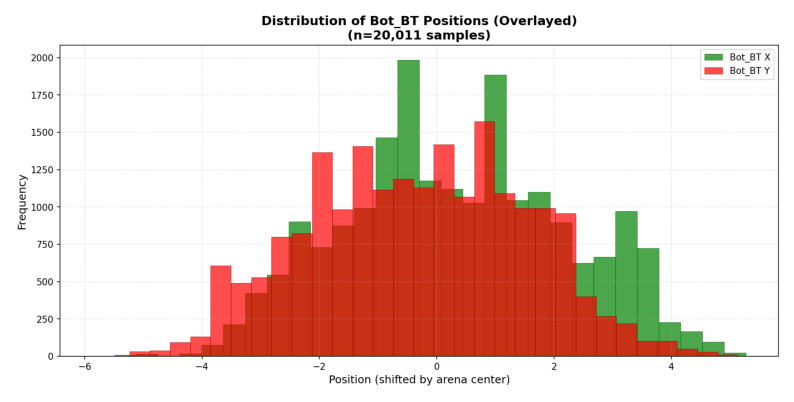


Full Configuration Analysis


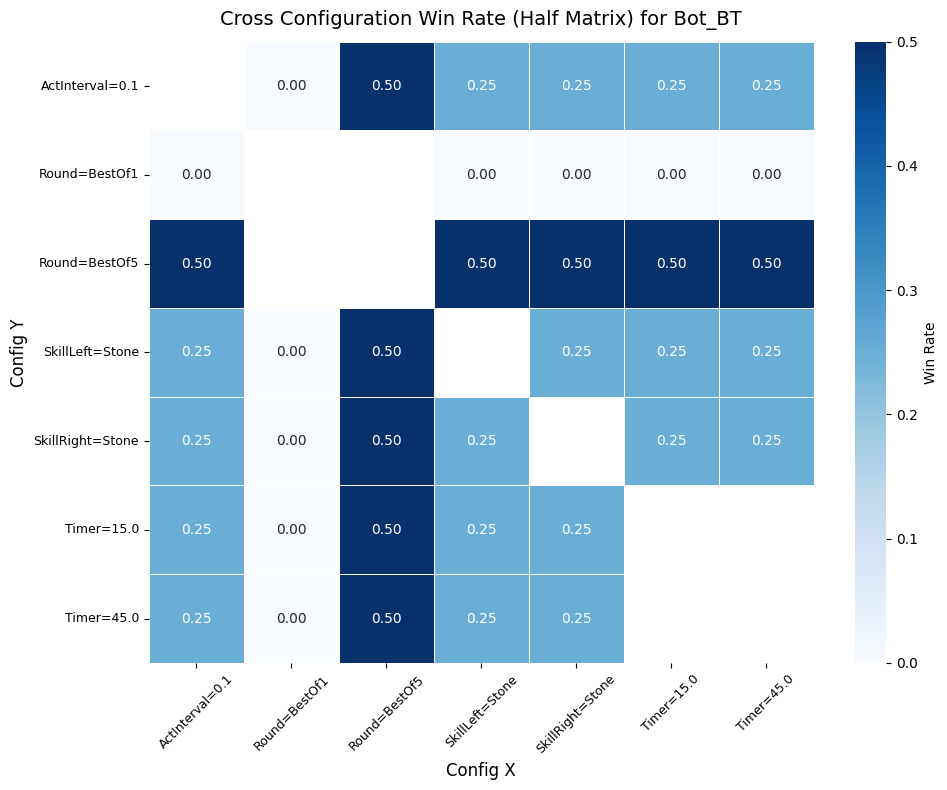

In [46]:
if os.path.exists(arena_heatmaps_output):
    # Get all bot directories
    bot_dirs = [d for d in os.listdir(arena_heatmaps_output)
               if os.path.isdir(os.path.join(arena_heatmaps_output, d))]
    
    # Sort bot directories by rank from df_sum
    if "Rank" in df_sum.columns and "Bot" in df_sum.columns:
        rank_map = df_sum.groupby("Bot")["Rank"].first().to_dict()
        bot_dirs = sorted(bot_dirs, key=lambda b: rank_map.get(b, 9999))
    else:
        bot_dirs = sorted(bot_dirs)
    
    if bot_dirs:
        phase_names = ["window_2.5-15s.png", "window_15-30s.png", "window_30-45s.png", "window_45-60s.png"]
        
        # Display heatmaps for each bot
        for bot_name in bot_dirs:
            print(f"\n{'='*60}")
            print(f"{bot_name} (#{bot_dirs.index(bot_name)+1})")
            print(f"{'='*60}")
            bot_dir = os.path.join(arena_heatmaps_output, bot_name)
            
            # Display phase heatmaps
            fig, axes = plt.subplots(1, len(phase_names), figsize=(20, 5))
            for idx, phase_name in enumerate(phase_names):
                image_path = os.path.join(bot_dir, phase_name)
                if os.path.exists(image_path):
                    image = Image.open(image_path)
                    axes[idx].imshow(image)
                    axes[idx].set_title(phase_name)
                    axes[idx].axis('off')
                else:
                    axes[idx].text(0.5, 0.5, f"Image not found:\n{phase_name}",
                                  ha='center', va='center')
                    axes[idx].axis('off')
            plt.tight_layout()
            plt.show()
            
            # Display position distribution
            dist_path = os.path.join(bot_dir, "position_distribution.png")
            if os.path.exists(dist_path):
                print("\nPosition Distribution (X & Y Overlayed)")
                dist_image = Image.open(dist_path)
                plt.figure(figsize=(10, 6))
                plt.imshow(dist_image)
                plt.axis('off')
                plt.show()
            
            # Display distance distribution
            dist_path = os.path.join(bot_dir, "distance_distribution.png")
            if os.path.exists(dist_path):
                print("\nDistance Distribution")
                dist_image = Image.open(dist_path)
                plt.figure(figsize=(10, 6))
                plt.imshow(dist_image)
                plt.axis('off')
                plt.show()

            print("\nFull Configuration Analysis")
            fig = plot_full_cross_heatmap_half(df, bot_name=bot_name)
            plt.show()
    else:
        print("No bot heatmaps found in directory")
        print("Run: `python detailed_analyzer.py all` to generate heatmaps")
else:
    print(f"Heatmap directory not found: {arena_heatmaps_output}")
    print("Run: `python detailed_analyzer.py all` to generate heatmaps for all bots")